In [216]:
print("Starting core imports...")

print("1. Importing feedparser")
import feedparser

print("2. Importing matplotlib.pyplot")
import matplotlib.pyplot as plt

print("3. Importing datetime")
from datetime import datetime, timedelta

print("4. Importing urllib.parse")
import urllib.parse

print("5. Importing pandas")
import pandas as pd

print("6. Importing yfinance")
import yfinance as yf

print("7. Importing numpy")
import numpy as np

print("11. Importing PyTorch")
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("12. Importing matplotlib.cm")
import matplotlib.cm as cm

print("13. Importing matplotlib.colors")
import matplotlib.colors as mcolors

print("14. Importing matplotlib.dates")
import matplotlib.dates as mdates

print("15. Importing scipy.stats")
from scipy.stats import norm

print("16. Importing pandas_market_calendars")
import pandas_market_calendars as mcal

print("17. Importing praw")
import praw

print("18. Importing TextBlob")
from textblob import TextBlob

print("19. Importing pytz")
import pytz

print("20. Importing warnings")
import warnings

print("21. Importing os, json, time, re, html")
import os, json, time, re, html

print("22. Importing requests")
import requests

print("23. Importing ThreadPoolExecutor and as_completed")
from concurrent.futures import ThreadPoolExecutor, as_completed

print("24. Importing typing")
from typing import List, Tuple, Dict, Any, Optional

print("25. Filtering warnings")
warnings.filterwarnings('ignore')

print("Core imports complete!")

Starting core imports...
1. Importing feedparser
2. Importing matplotlib.pyplot
3. Importing datetime
4. Importing urllib.parse
5. Importing pandas
6. Importing yfinance
7. Importing numpy
11. Importing PyTorch
12. Importing matplotlib.cm
13. Importing matplotlib.colors
14. Importing matplotlib.dates
15. Importing scipy.stats
16. Importing pandas_market_calendars
17. Importing praw
18. Importing TextBlob
19. Importing pytz
20. Importing warnings
21. Importing os, json, time, re, html
22. Importing requests
23. Importing ThreadPoolExecutor and as_completed
24. Importing typing
25. Filtering warnings
Core imports complete!


In [217]:
import time

start = time.time()
from sklearn.model_selection import train_test_split
end = time.time()
print(f"train_test_split import: {end - start:.2f} seconds")

start = time.time()
from sklearn.preprocessing import MinMaxScaler
end = time.time()
print(f"MinMaxScaler import: {end - start:.2f} seconds")

start = time.time()
from sklearn.metrics import mean_squared_error
end = time.time()
print(f"mean_squared_error import: {end - start:.2f} seconds")


train_test_split import: 0.00 seconds
MinMaxScaler import: 0.00 seconds
mean_squared_error import: 0.00 seconds


### Code used to fetch Reddit data

In [218]:
class RedditDataFetcher:
    def __init__(self,
                 client_id: str = "KtBWOuzlXU2pRXEWWM52LQ",
                 client_secret: str = "PPadrWEweAwNVeT9ob3h3qq6Id6BDg",
                 user_agent: str = "PIC Project/0.1 by Ecstatic-String-3135",
                 max_search_workers: int = 6,
                 max_comment_workers: int = 4,
                 time_filter: str = "year"):  # <-- deeper pool so Aug 1–9 is included
        self.creds = dict(client_id=client_id, client_secret=client_secret, user_agent=user_agent)
        self.max_search_workers = max(1, max_search_workers)
        self.max_comment_workers = max(1, max_comment_workers)
        self.time_filter = time_filter    # 'hour'|'day'|'week'|'month'|'year'|'all'
        self.PST = pytz.timezone("US/Pacific")

        # General/broad search terms (no CloudSearch). We'll filter strictly later.
        self.search_queries = [
            "stock", "market", "investing", "stocks",
            "SPY", "$SPY", "SP500", "SP 500", "SPX", "^GSPC",
            "S&P", "S and P", "S P 500", "SPDR", "index fund"
        ]

        # Local keep-if matches any (normalize first).
        self.required_keywords = [
            r"\bs&p\s*500\b", r"\bs&amp;p\s*500\b", r"s\s*&\s*p\s*500", r"s\s*and\s*p\s*500",
            r"\bs&p500\b", r"\bs&amp;p500\b", r"\bsp500\b", r"\bsp\s*500\b",
            r"\bsnp\s*500\b", r"\bsnp\s*index\b", r"\^gspc\b", r"\bspdr\b", r"stock\s+market",
            r"\bs&p\b", r"\bs&amp;p\b",                     # optional: allow plain “S&P”
            r"(?<![a-z])\$?\s*spy(?![a-z])",               # SPY / $SPY / SPY450c
            r"(?<![a-z])spx(?![a-z])",                     # SPX / SPX4800p / spx-0dte
        ]
        self.required_pattern = re.compile("|".join(self.required_keywords), flags=re.IGNORECASE)

    # ---------------- Helpers ----------------
    def _new_reddit(self) -> praw.Reddit:
        return praw.Reddit(**self.creds)

    def _prev_full_month(self) -> Tuple[datetime, datetime]:
        now = datetime.now(self.PST)
        first_this = self.PST.localize(datetime(now.year, now.month, 1).replace(tzinfo=None))
        prev_start = (first_this - timedelta(days=1)).replace(day=1)
        prev_end = first_this  # [start, end)
        return prev_start, prev_end

    def _resolve_window(self, start: Optional[str], end: Optional[str]) -> Tuple[datetime, datetime]:
        if start and end:
            return (self.PST.localize(datetime.fromisoformat(start)),
                    self.PST.localize(datetime.fromisoformat(end)))
        return self._prev_full_month()

    @staticmethod
    def _normalize_text(s: str) -> str:
        s = html.unescape(s or "")
        s = s.replace("\u2019", "'").replace("\u2018", "'")
        s = s.replace("\u2013", "-").replace("\u2014", "-")
        s = s.lower()
        s = re.sub(r"\s+", " ", s).strip()
        return s

    @staticmethod
    def _normalize_title_key(title: str) -> str:
        t = html.unescape(title or "")
        t = t.lower()
        t = re.sub(r"[\s\-\_\|\·\•\:\;\,\.\!\?\(\)\[\]\{\}\"'\u2019\u2018\u2013\u2014]+", " ", t)
        t = t.strip()
        return t

    def _matches_required(self, title: str, body: str) -> bool:
        text = self._normalize_text(f"{title} {body}")
        return bool(self.required_pattern.search(text))

    @staticmethod
    def _analyze(text: str) -> Tuple[float, float, float]:
        blob = TextBlob(text or "")
        p = blob.sentiment.polarity
        s = blob.sentiment.subjectivity
        scaled = s * 9 + 1
        return float(p * scaled), float(p), float(scaled)

    # ---------------- Stage A: broad search per query ----------------
    def _fetch_for_query(self, query: str, start_dt: datetime, end_dt: datetime) -> List[Dict[str, Any]]:
        r = self._new_reddit()
        out: List[Dict[str, Any]] = []
        pulled = kept = 0
        try:
            for s in r.subreddit("all").search(query, sort="new", time_filter=self.time_filter, limit=None):
                pulled += 1
                created_pst = datetime.fromtimestamp(s.created_utc, tz=pytz.utc).astimezone(self.PST)
                if created_pst < start_dt or created_pst >= end_dt:
                    continue
                title = s.title or ""
                body = s.selftext or ""
                if not self._matches_required(title, body):
                    continue
                post_w, post_p, post_s = self._analyze(f"{title} {body}")
                out.append({
                    "reddit_id": s.id,            # only used to fetch comments
                    "created_utc": s.created_utc,
                    "date": created_pst.strftime('%Y-%m-%d'),
                    "title": title,
                    "title_key": self._normalize_title_key(title),  # <-- dedup key
                    "body": body if body else "[No Content]",
                    "queries_hit": {query},
                    "post_weighted_polarity": post_w,
                    "post_polarity": post_p,
                    "post_subjectivity": post_s,
                })
                kept += 1
                # Optional progress line every 100 keeps per query
                if kept and kept % 100 == 0:
                    print(f"  [{query}] kept {kept} (pulled {pulled})...")
        except Exception as e:
            print(f"[Stage A] Query '{query}' error: {e}")
        # Per-query summary
        print(f"[Stage A] Finished '{query}': pulled {pulled}, kept {kept}")
        return out

    # ---------------- Stage B: ALL comments ----------------
    def _augment_with_comments(self, row: Dict[str, Any]) -> Dict[str, Any]:
        r = self._new_reddit()
        try:
            s = r.submission(id=row["reddit_id"])
            s.comments.replace_more(limit=None)
            vals = [row["post_weighted_polarity"]]
            for c in s.comments.list():
                cw, _, _ = self._analyze(getattr(c, "body", ""))
                vals.append(cw)
            combined = float(np.mean(vals)) if vals else row["post_weighted_polarity"]
        except Exception as e:
            print(f"[Stage B] Comments skipped for {row['reddit_id']}: {e}")
            combined = row["post_weighted_polarity"]
        row["comments_weighted_polarity"] = combined
        row["combined_sentiment"] = combined
        return row

    # ---------------- Public API ----------------
    def fetch_and_analyze_reddit_data(self,
                                      start: Optional[str] = None,
                                      end: Optional[str] = None) -> pd.DataFrame:
        start_dt, end_dt = self._resolve_window(start, end)
        print(f"Window PST: {start_dt.date()} → {end_dt.date()} (exclusive); time_filter='{self.time_filter}'")

        # Stage A: run all queries in parallel
        raw_posts: List[Dict[str, Any]] = []
        with ThreadPoolExecutor(max_workers=self.max_search_workers) as ex:
            futs = [ex.submit(self._fetch_for_query, q, start_dt, end_dt) for q in self.search_queries]
            for f in as_completed(futs):
                raw_posts.extend(f.result() or [])

        # ---- DEDUP BY TITLE ----
        by_title: Dict[str, Dict[str, Any]] = {}
        for r in raw_posts:
            k = r["title_key"]
            # Keep the most recent if same title appears multiple times
            if k not in by_title or r["created_utc"] > by_title[k]["created_utc"]:
                by_title[k] = r
            else:
                # Even if we keep the older/newer decision, union the queries that hit
                by_title[k]["queries_hit"].update(r.get("queries_hit", set()))

        base_rows = list(by_title.values())
        # Convert queries_hit set → semicolon string for readability
        for r in base_rows:
            r["queries_hit"] = "; ".join(sorted(r["queries_hit"]))

        print(f"Stage A unique titles: {len(base_rows)}")

        # Stage B: comments in parallel
        augmented: List[Dict[str, Any]] = []
        with ThreadPoolExecutor(max_workers=self.max_comment_workers) as ex:
            futs = [ex.submit(self._augment_with_comments, row) for row in base_rows]
            for f in as_completed(futs):
                augmented.append(f.result())

        # Final defensive dedup by title_key at the end as well
        seen_titles = set()
        unique_rows: List[Dict[str, Any]] = []
        for r in augmented:
            k = r["title_key"]
            if k in seen_titles:
                continue
            seen_titles.add(k)
            unique_rows.append(r)

        df = pd.DataFrame(unique_rows)
        if not df.empty:
            df = df.drop_duplicates(subset=["title_key"]).reset_index(drop=True)
        print(f"Stage B augmented posts (unique titles): {len(df)}")
        return df

    def save_sentiment_data_to_json(self, df: pd.DataFrame,
                                    start: Optional[str] = None,
                                    end: Optional[str] = None,
                                    out_path: str = "sentiment_data.json"):
        start_dt, end_dt = self._resolve_window(start, end)
        all_dates = pd.date_range(start=start_dt, end=end_dt - timedelta(days=1), freq='D', tz=self.PST)

        bucket = {
            d.strftime('%Y-%m-%d'): {
                "date": d.strftime('%Y-%m-%d'),
                "posts": [],
                "post_count": 0,
                "average_combined_sentiment": 0.0,
                "_seen_titles": set()  # enforce uniqueness per day by title
            } for d in all_dates
        }

        if df is not None and not df.empty:
            for _, row in df.iterrows():
                k = str(row["date"])
                if k not in bucket:
                    continue
                title_key = str(row["title_key"])
                if title_key in bucket[k]["_seen_titles"]:
                    continue
                bucket[k]["_seen_titles"].add(title_key)

                post_obj = {c: row[c] for c in df.columns}
                bucket[k]["posts"].append(post_obj)
                bucket[k]["post_count"] += 1
                bucket[k]["average_combined_sentiment"] += float(row["combined_sentiment"])

        for d in bucket.values():
            if d["post_count"] > 0:
                d["average_combined_sentiment"] /= d["post_count"]
            d.pop("_seen_titles", None)

        with open(out_path, "w") as f:
            json.dump({"days": bucket}, f, indent=4)
        print(f"Wrote {out_path}")

In [219]:
# DATA GENERATION CELL - COMMENTED OUT (using existing sentiment_prev_full_month.json)
# fetcher = RedditDataFetcher()
# df = fetcher.fetch_and_analyze_reddit_data()  # defaults to previous full month
# fetcher.save_sentiment_data_to_json(df, out_path="sentiment_prev_full_month.json")

### Helper functions for loading and creating models with the Reddit data

In [220]:
def load_sentiment_data(json_file):
    """
    Loads sentiment data from a JSON file and returns a DataFrame.

    Parameters:
        json_file (str): Path to the JSON file.

    Returns:
        pd.DataFrame: Sentiment data with columns for date, post_count, and average_combined_sentiment.
    """
    with open(json_file, 'r') as f:
        data = json.load(f)
    records = []
    for day in data["days"].values():
        records.append({
            "date": day["date"],
            "post_count": day["post_count"],
            "average_combined_sentiment": day["average_combined_sentiment"]
        })
    return pd.DataFrame(records)


def fetch_spy_prices(lookback=100):
    """
    Fetches historical SPY prices for a specified lookback period from today.

    Parameters:
        lookback (int): Number of days to look back from the current date.

    Returns:
        pd.Series: Adjusted close prices for SPY.
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=lookback)
    spy_data = yf.download("SPY", start=start_date, end=end_date)
    spy_data.index = pd.to_datetime(spy_data.index)
    return spy_data['Close']


def fetch_vix_data(lookback=60):
    """
    Fetches historical VIX data for a specified lookback period.

    Parameters:
        lookback (int): Number of days to look back from the current date.

    Returns:
        pd.Series: Adjusted close values for the VIX index.
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=lookback)
    vix_data = yf.download("^VIX", start=start_date, end=end_date)
    vix_data.index = pd.to_datetime(vix_data.index)
    return vix_data['Close']


def adjust_sentiment_to_trading_days(sentiments, prices):
    """
    Aligns sentiment data with trading days. Sentiment from non-trading days
    is applied to the next available trading day, and post counts are summed.

    Parameters:
        sentiments (pd.DataFrame): DataFrame with sentiment data indexed by date.
        prices (pd.Series): Price data used to determine trading days.

    Returns:
        pd.DataFrame: Adjusted sentiment data aligned with trading days.
    """
    # Ensure 'date' is in datetime format
    sentiments['date'] = pd.to_datetime(sentiments['date'])

    # Set 'date' as the index
    sentiments.set_index('date', inplace=True)

    # Ensure sentiments index is timezone-aware if prices are timezone-aware
    if prices.index.tz is not None:
        sentiments.index = sentiments.index.tz_localize('UTC', ambiguous='NaT')  # Localize if naive
        sentiments.index = sentiments.index.tz_convert(prices.index.tz)  # Convert to the timezone of prices

    trading_days = prices.index
    adjusted_records = []

    # Loop through the sentiment data and match it with trading days
    for date, row in sentiments.iterrows():
        # Ensure date is timezone-aware
        if date.tzinfo is None:
            date = date.tz_localize(prices.index.tz)  # Localize if naive

        # Find the next trading day
        next_trading_day = trading_days[trading_days >= date].min()

        if pd.notna(next_trading_day):
            adjusted_records.append({
                'date': next_trading_day,
                'average_combined_sentiment': row['average_combined_sentiment'],
                'post_count': row['post_count']
            })

    # Create a DataFrame from the adjusted records
    adjusted_df = pd.DataFrame(adjusted_records)

    # Group by 'date' to aggregate sentiment and post counts
    adjusted_df = adjusted_df.groupby('date').agg(
        average_combined_sentiment=('average_combined_sentiment', 'mean'),
        post_count=('post_count', 'sum')
    )

    return adjusted_df



def prepare_lstm_data(sentiments, historical_volatility, lookback=14):
    """
    Prepares data for LSTM model training by merging sentiment and volatility data,
    scaling them, and creating sequences.

    Parameters:
        sentiments (pd.DataFrame): Sentiment data aligned with trading days.
        historical_volatility (pd.DataFrame): Volatility data.
        lookback (int): Number of days to look back for sequence creation.

    Returns:
        tuple: (X, y, scaler, merged_data)
    """
    sentiments = sentiments[~sentiments.index.duplicated(keep='first')]
    historical_volatility = historical_volatility[~historical_volatility.index.duplicated(keep='first')]

    common_index = sentiments.index.intersection(historical_volatility.index)
    sentiments = sentiments.loc[common_index]
    historical_volatility = historical_volatility.loc[common_index]

    merged_data = pd.concat([sentiments, historical_volatility], axis=1, join="inner")
    merged_data.dropna(inplace=True)

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(merged_data)

    if len(scaled_data) <= lookback:
        raise ValueError(f"Not enough data points ({len(scaled_data)}) for the specified lookback ({lookback}).")

    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i - lookback:i])
        y.append(scaled_data[i, 2])  # historical_volatility assumed to be at index 2
    X, y = np.array(X), np.array(y)
    
    return X, y, scaler, merged_data


def calculate_historical_volatility(prices):
    """
    Calculates historical volatility using log returns and rolling window standard deviation.

    Parameters:
        prices (pd.Series): Price data for the underlying.

    Returns:
        pd.DataFrame: Annualized historical volatility.
    """
    log_returns = np.log(prices / prices.shift(1)).dropna()
    rolling_volatility = log_returns.rolling(window=30, min_periods=30).std()
    annualized_volatility = rolling_volatility * np.sqrt(252)
    annualized_volatility = pd.DataFrame(annualized_volatility)
    annualized_volatility.rename(columns={'SPY': 'historical_volatility'}, inplace=True)
    return annualized_volatility


class LSTMModel(nn.Module):
    """
    PyTorch LSTM model for volatility prediction.
    
    Architecture:
        - LSTM layer 1: 50 units, returns sequences
        - Dropout: 0.2
        - LSTM layer 2: 50 units
        - Dropout: 0.2
        - Dense output: 1 unit
    """
    def __init__(self, input_size, hidden_size=50, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        # Take the output from the last time step
        out = lstm_out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out


def train_lstm_model(X, y, epochs=50, batch_size=32):
    """
    Builds and trains an LSTM model on the given data.

    Parameters:
        X (np.ndarray): Training features.
        y (np.ndarray): Training targets.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        nn.Module: Trained PyTorch LSTM model.
    """
    # Convert numpy arrays to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y.reshape(-1, 1))
    
    # Get input size from data shape
    input_size = X.shape[2]
    
    # Create the model
    model = LSTMModel(input_size=input_size)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    # Training loop
    model.train()
    n_samples = X_tensor.shape[0]
    
    for epoch in range(epochs):
        # Shuffle indices for each epoch
        indices = torch.randperm(n_samples)
        
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:min(i + batch_size, n_samples)]
            X_batch = X_tensor[batch_indices]
            y_batch = y_tensor[batch_indices]
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    return model


def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    Computes the price of a European option using the Black-Scholes formula.

    Parameters:
        S (float): Current underlying price.
        K (float): Strike price.
        T (float): Time to expiration in years.
        r (float): Risk-free interest rate.
        sigma (float): Volatility.
        option_type (str): "call" or "put".

    Returns:
        float: The computed option price.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

    return price


def predict_next_week_volatility(model, scaler, merged_data, trading_days, days=9, lookback=14):
    """
    Predicts future implied volatility for a specified number of trading days ahead.

    Parameters:
        model (nn.Module): Trained PyTorch LSTM model.
        scaler (MinMaxScaler): Scaler used to scale the input data.
        merged_data (pd.DataFrame): Data on which the model was trained.
        trading_days (pd.DatetimeIndex): Trading days used for generating future predictions.
        days (int): Number of future days to predict.
        lookback (int): Length of the lookback window.

    Returns:
        tuple: (future_dates, future_predictions)
    """
    scaled_data = scaler.transform(merged_data)

    if len(scaled_data) < lookback:
        raise ValueError(f"Not enough data points ({len(scaled_data)}) for the specified lookback ({lookback}).")

    future_X = scaled_data[-lookback:].reshape(1, lookback, scaled_data.shape[1])
    future_predictions = []

    nyse = mcal.get_calendar('NYSE')
    start_date = trading_days[0]
    trading_schedule = nyse.schedule(start_date=start_date, end_date=start_date + pd.Timedelta(days=100))

    first_prediction_date = trading_schedule.index[lookback]
    trading_schedule = trading_schedule.loc[first_prediction_date:]
    future_dates = trading_schedule.index[:days]

    # Set model to evaluation mode
    model.eval()
    
    for _ in range(days):
        # Convert to tensor and predict
        future_X_tensor = torch.FloatTensor(future_X)
        with torch.no_grad():
            next_prediction = model(future_X_tensor).cpu().numpy()
        
        rescaled_prediction = scaler.inverse_transform(
            np.hstack([np.zeros((1, scaler.n_features_in_ - 1)), next_prediction])
        )[0, -1]

        rescaled_prediction = max(rescaled_prediction, 1e-6)
        future_predictions.append(rescaled_prediction)

        next_prediction_scaled = np.hstack([future_X[0, -1, :-1], next_prediction.flatten()]).reshape(1, -1)
        next_input = np.append(future_X[:, 1:, :], next_prediction_scaled.reshape(1, 1, -1), axis=1)
        future_X = next_input

    return future_dates, future_predictions


def fetch_actual_options_prices(symbol, dates, strike_prices, maturity_days=30):
    """
    Fetches actual options prices for a given symbol over specified future dates and strike prices.

    Parameters:
        symbol (str): Underlying symbol for which options data is retrieved.
        dates (list of pd.Timestamp): Dates for which to fetch options data.
        strike_prices (list of float): Strike prices of interest.
        maturity_days (int): Number of trading days to expiration.

    Returns:
        dict: Mapping from date to a list of options data (strike, lastPrice).
    """
    options_data = {}
    ticker = yf.Ticker(symbol)
    expiration_dates = [pd.to_datetime(date_str) for date_str in ticker.options]
    expiration_dates.sort()

    for date in dates:
        try:
            target_expiration_date = pd.bdate_range(start=date, periods=maturity_days + 1)[-1]
            future_expirations = [exp_date for exp_date in expiration_dates if exp_date >= target_expiration_date]
            if not future_expirations:
                print(f"No available expiration dates after {target_expiration_date.date()} for symbol {symbol}")
                options_data[date] = []
                continue

            closest_expiration = future_expirations[0]
            expiration_str = closest_expiration.strftime('%Y-%m-%d')
            options_chain = ticker.option_chain(expiration_str)
            calls = options_chain.calls

            if calls.empty:
                print(f"No call options data available for expiration date {expiration_str}")
                options_data[date] = []
                continue

            filtered_calls = calls[calls['strike'].isin(5 * np.ceil(strike_prices.round(0)/5))]
            if filtered_calls.empty:
                print(f"No options found for {date.date()} with the specified strike prices.")
                options_data[date] = []
                continue

            options_data[date] = filtered_calls[['strike', 'lastPrice']].to_dict('records')

        except Exception as e:
            print(f"Error fetching options for {date.date()}: {e}")
            options_data[date] = []

    return options_data

### Main class that stores json Reddit data and creates the desired output when ran (Graphs of sentiment/stock data)

In [221]:
class VolatilityAnalysisRunner:
    """
    Encapsulates the main logic for volatility analysis, including:
    - Loading sentiment data
    - Fetching market prices
    - Preparing and training the LSTM model
    - Predicting future volatility
    - Plotting results and computing correlations
    """

    def __init__(self, json_file="sentiment_data.json"):
        """
        Initializes the runner with the sentiment JSON file.

        Parameters:
            json_file (str): Path to the sentiment JSON file.
        """
        self.json_file = json_file

    def run(self):
        """
        Runs the full data processing and analysis pipeline:
        Loads sentiment data, fetches prices, trains the LSTM, predicts volatility,
        calculates Black-Scholes prices, fetches actual option prices, plots various metrics,
        and computes correlation metrics.
        """
        # Load sentiment data first to determine date range
        sentiment_data = load_sentiment_data(self.json_file)
        
        # Determine date range from sentiment data
        sentiment_dates = pd.to_datetime(sentiment_data['date'])
        start_date = sentiment_dates.min() - timedelta(days=60)  # Extra buffer for volatility calculation
        end_date = sentiment_dates.max() + timedelta(days=10)  # Buffer for predictions
        
        # Fetch SPY prices for the sentiment date range
        spy_data = yf.download("SPY", start=start_date, end=end_date)
        spy_data.index = pd.to_datetime(spy_data.index)
        spy_prices = spy_data['Close']
        
        # Fetch VIX data for the sentiment date range
        vix_data = yf.download("^VIX", start=start_date, end=end_date)
        vix_data.index = pd.to_datetime(vix_data.index)
        vix_data = vix_data['Close'] / 100
        
        historical_volatility = calculate_historical_volatility(spy_prices)
        adjusted_sentiments = adjust_sentiment_to_trading_days(sentiment_data, spy_prices)

        lookback = 14
        X, y, scaler, merged_data = prepare_lstm_data(adjusted_sentiments, vix_data, lookback=lookback)
        lstm_model = train_lstm_model(X, y)
        future_dates, future_volatilities = predict_next_week_volatility(
            lstm_model, scaler, merged_data, trading_days=merged_data.index, days=9, lookback=lookback
        )

        future_dates = pd.DatetimeIndex(future_dates)
        valid_future_dates = future_dates.intersection(historical_volatility.index)
        future_volatilities = future_volatilities[:len(valid_future_dates)]
        actual_volatilities = historical_volatility.loc[valid_future_dates, "historical_volatility"]

        S = spy_prices.iloc[-1][0] if hasattr(spy_prices.iloc[-1], '__len__') else spy_prices.iloc[-1]
        T = 30 / 365
        r = 0.05
        strike_prices = np.arange(S * 0.98, S * 1.02, 5)  
        strike_prices = 5 * np.ceil(strike_prices.round(0)/5)

        option_prices_data = []
        for sigma, date in zip(future_volatilities, valid_future_dates):
            call_prices = [black_scholes(S, K, T, r, sigma, option_type="call") for K in strike_prices]
            option_prices_data.append((date, call_prices))

        # Ensure sentiment_data index is of datetime type
        sentiment_data['date'] = pd.to_datetime(sentiment_data.index)
        post_counts = sentiment_data["post_count"]
        avg_sentiment = sentiment_data["average_combined_sentiment"]
        
        # Align sentiment_data with historical_volatility by intersecting indices
        sentiment_data = sentiment_data.loc[sentiment_data.index.intersection(historical_volatility.index)]
        
        # --- make all indexes tz-naive and DAY-ONLY (normalize) ---
        adjusted_sentiments.index = pd.to_datetime(adjusted_sentiments.index).tz_localize(None).normalize()
        historical_volatility.index = pd.to_datetime(historical_volatility.index).tz_localize(None).normalize()
        vix_data.index = pd.to_datetime(vix_data.index).tz_localize(None).normalize()

        # --- guard: need at least 1 row of sentiment after alignment ---
        if adjusted_sentiments.empty:
            raise ValueError("No rows in adjusted_sentiments; check JSON path/window and alignment to trading days.")

        # === WINDOW BOUNDS (date-only) ===
        # sentiment bounds from the data
        s0 = adjusted_sentiments.index.min()
        s1 = adjusted_sentiments.index.max()

        # volatility bounds = overlap across HV, VIX, and sentiment
        vol_start_candidates = [historical_volatility.index.min(), vix_data.index.min(), s0]
        vol_end_candidates   = [historical_volatility.index.max(), vix_data.index.max(), s1]
        v0 = max([d for d in vol_start_candidates if pd.notna(d)])
        v1 = min([d for d in vol_end_candidates   if pd.notna(d)])

        # --- EXCLUSIVE-END SLICES (avoid off-by-one) ---
        s1_excl = s1 + pd.Timedelta(days=1)
        v1_excl = v1 + pd.Timedelta(days=1)

        # === FILTERING ===
        filtered_sentiment_scores = adjusted_sentiments.loc[(adjusted_sentiments.index >= s0) &
                                                            (adjusted_sentiments.index <  s1_excl)]
        filtered_post_counts = filtered_sentiment_scores["post_count"]

        filtered_historical_volatility = historical_volatility.loc[(historical_volatility.index >= v0) &
                                                                (historical_volatility.index <  v1_excl)]
        filtered_vix_data = vix_data.loc[(vix_data.index >= v0) &
                                        (vix_data.index <  v1_excl)]
        
        # Fetch the actual options data (no change here)
        symbol = "SPY"
        actual_options_data = fetch_actual_options_prices(symbol, valid_future_dates, strike_prices)

        fig1, axes1 = plt.subplots(2, 2, figsize=(18, 16), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})

        axes1[0, 0].plot(filtered_historical_volatility.index, filtered_historical_volatility['historical_volatility'], label="Historical Volatility", marker='o')
        axes1[0, 0].plot(valid_future_dates, future_volatilities, label="Predicted Volatility", marker='x')
        axes1[0, 0].set_title("Historical and Predicted Implied Volatility", fontsize=12)
        axes1[0, 0].set_ylabel("Implied Volatility", fontsize=10)
        axes1[0, 0].legend(fontsize=8)
        axes1[0, 0].grid()

        axes1[0, 1].plot(filtered_sentiment_scores.index, filtered_sentiment_scores['average_combined_sentiment'], label="Avg Combined Sentiment", color="green")
        axes1[0, 1].set_title("Average Combined Sentiment Over Time", fontsize=12)
        axes1[0, 1].set_ylabel("Sentiment Score", fontsize=10)
        axes1[0, 1].legend(fontsize=8)
        axes1[0, 1].grid()

        axes1[1, 1].plot(filtered_post_counts.index, merged_data['post_count'], label="Post Counts", color="blue")
        axes1[1, 1].set_title("Post Counts Over Time", fontsize=12)
        axes1[1, 1].set_xlabel("Date", fontsize=10)
        axes1[1, 1].set_ylabel("Post Counts", fontsize=10)
        axes1[1, 1].legend(fontsize=8)
        axes1[1, 1].grid()

        axes1[1, 0].plot(filtered_vix_data.index, filtered_vix_data, label="Implied Volatilities", color="purple", marker='d', linestyle='--')
        axes1[1, 0].set_title("VIX Prices Over Time", fontsize=12)
        axes1[1, 0].set_xlabel("Date", fontsize=10)
        axes1[1, 0].set_ylabel("VIX Price", fontsize=10)
        axes1[1, 0].legend(fontsize=8)
        axes1[1, 0].grid()

        for ax in axes1.flat:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
            ax.tick_params(axis='x', rotation=45)

        plt.show()
        
        # ==== FIGURE 2: option price curves (predicted vs actual) ====
        fig2, axes2 = plt.subplots(1, 2, figsize=(18, 7))
        axes2[0].set_title("Predicted Call Curves")
        axes2[0].set_xlabel("Strike")
        axes2[0].set_ylabel("Price")
        axes2[0].grid(True)

        axes2[1].set_title("Actual Call Curves")
        axes2[1].set_xlabel("Strike")
        axes2[1].set_ylabel("Price")
        axes2[1].grid(True)

        if len(option_prices_data) > 0:
            # color by date
            pred_dates = [d for d, _ in option_prices_data]
            numeric_dates = mdates.date2num(pred_dates)
            norm = mcolors.Normalize(vmin=min(numeric_dates), vmax=max(numeric_dates))
            colormap = cm.viridis

            # Predicted curves
            for date, call_prices in option_prices_data:
                color = colormap(norm(mdates.date2num(date)))
                axes2[0].plot(
                    strike_prices,
                    call_prices,
                    label=f"Pred ({date.strftime('%m/%d')})",
                    linestyle="--",
                    marker=None,
                    color=color,
                )
            axes2[0].legend(fontsize=8)

            # Actual curves (for the same dates, when available)
            for date, _ in option_prices_data:
                if date in actual_options_data and actual_options_data[date]:
                    actual_prices = {item["strike"]: item["lastPrice"] for item in actual_options_data[date]}
                    actual_strikes = np.array(sorted(actual_prices.keys()), dtype=float)
                    actual_values  = np.array([actual_prices[s] for s in actual_strikes], dtype=float)
                    axes2[1].plot(
                        actual_strikes,
                        actual_values,
                        label=f"Actual ({date.strftime('%m/%d')})",
                        linestyle="-",
                        marker="o"
                    )
            axes2[1].legend(fontsize=8)
        else:
            axes2[0].text(0.5, 0.5, "No predicted curves to plot", ha="center", va="center", transform=axes2[0].transAxes)
            axes2[1].text(0.5, 0.5, "No actual curves to plot", ha="center", va="center", transform=axes2[1].transAxes)

        plt.show()


        # === CORRELATIONS (aligned index; force Series) ===
        # Build a common date index across the three sources
        corr_idx = adjusted_sentiments.index \
            .intersection(vix_data.index) \
            .intersection(historical_volatility.index)
        corr_idx = corr_idx.sort_values()

        # Optional: focus on a recent window (e.g., last 30 aligned days)
        window = 30
        if len(corr_idx) > window:
            corr_idx = corr_idx[-window:]

        # ---- Force each input to be a 1-D Series on the same index ----
        # Historical vol: already a DF; select the column -> Series
        hv = historical_volatility.loc[corr_idx, "historical_volatility"]
        if isinstance(hv, pd.DataFrame):
            hv = hv.iloc[:, 0]
        hv = hv.astype(float).rename("Historical Volatility")

        # VIX: vix_data might be Series or 1-col DataFrame; coerce to Series
        vix = vix_data.loc[corr_idx]
        if isinstance(vix, pd.DataFrame):
            if vix.shape[1] == 1:
                vix = vix.iloc[:, 0]
            else:
                # if multiple columns slipped in, prefer 'Adj Close' or 'Close'
                col = "Adj Close" if "Adj Close" in vix.columns else ("Close" if "Close" in vix.columns else vix.columns[0])
                vix = vix[col]
        vix = vix.astype(float).rename("VIX Prices")

        # Sentiment features: Series already
        acs = adjusted_sentiments.loc[corr_idx, "average_combined_sentiment"].astype(float).rename("Average Combined Sentiment")
        pc  = adjusted_sentiments.loc[corr_idx, "post_count"].astype(float).rename("Post Counts")

        # Assemble aligned DF
        corr_df = pd.concat([hv, vix, acs, pc], axis=1).dropna()

        if corr_df.empty:
            print("Correlation Matrix: (no overlapping rows after alignment)")
        else:
            print("Correlation Matrix:")
            print(corr_df.corr())

        filtered_predicted_prices = []
        filtered_actual_prices = []
        for date, predicted_prices in option_prices_data:
            if date in actual_options_data and actual_options_data[date]:
                actual_data = actual_options_data[date]
                actual_strike_price_map = {item['strike']: item['lastPrice'] for item in actual_data}
                for strike, predicted_price in zip(strike_prices, predicted_prices):
                    if strike in actual_strike_price_map:
                        filtered_predicted_prices.append(predicted_price)
                        filtered_actual_prices.append(actual_strike_price_map[strike])

        if filtered_predicted_prices and filtered_actual_prices:
            predicted_series = pd.Series(filtered_predicted_prices, name="Predicted Prices", dtype=float)
            actual_series = pd.Series(filtered_actual_prices, name="Actual Prices", dtype=float)

            correlation = predicted_series.corr(actual_series)
            mse = mean_squared_error(actual_series, predicted_series)
            rmse = np.sqrt(mse)
            mape = (np.abs((actual_series - predicted_series) / actual_series).mean()) * 100

            print("Metrics between predicted and actual option prices:")
            print(f"Correlation: {correlation:.4f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
        else:
            print("No overlapping strike prices found between predicted and actual options.")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


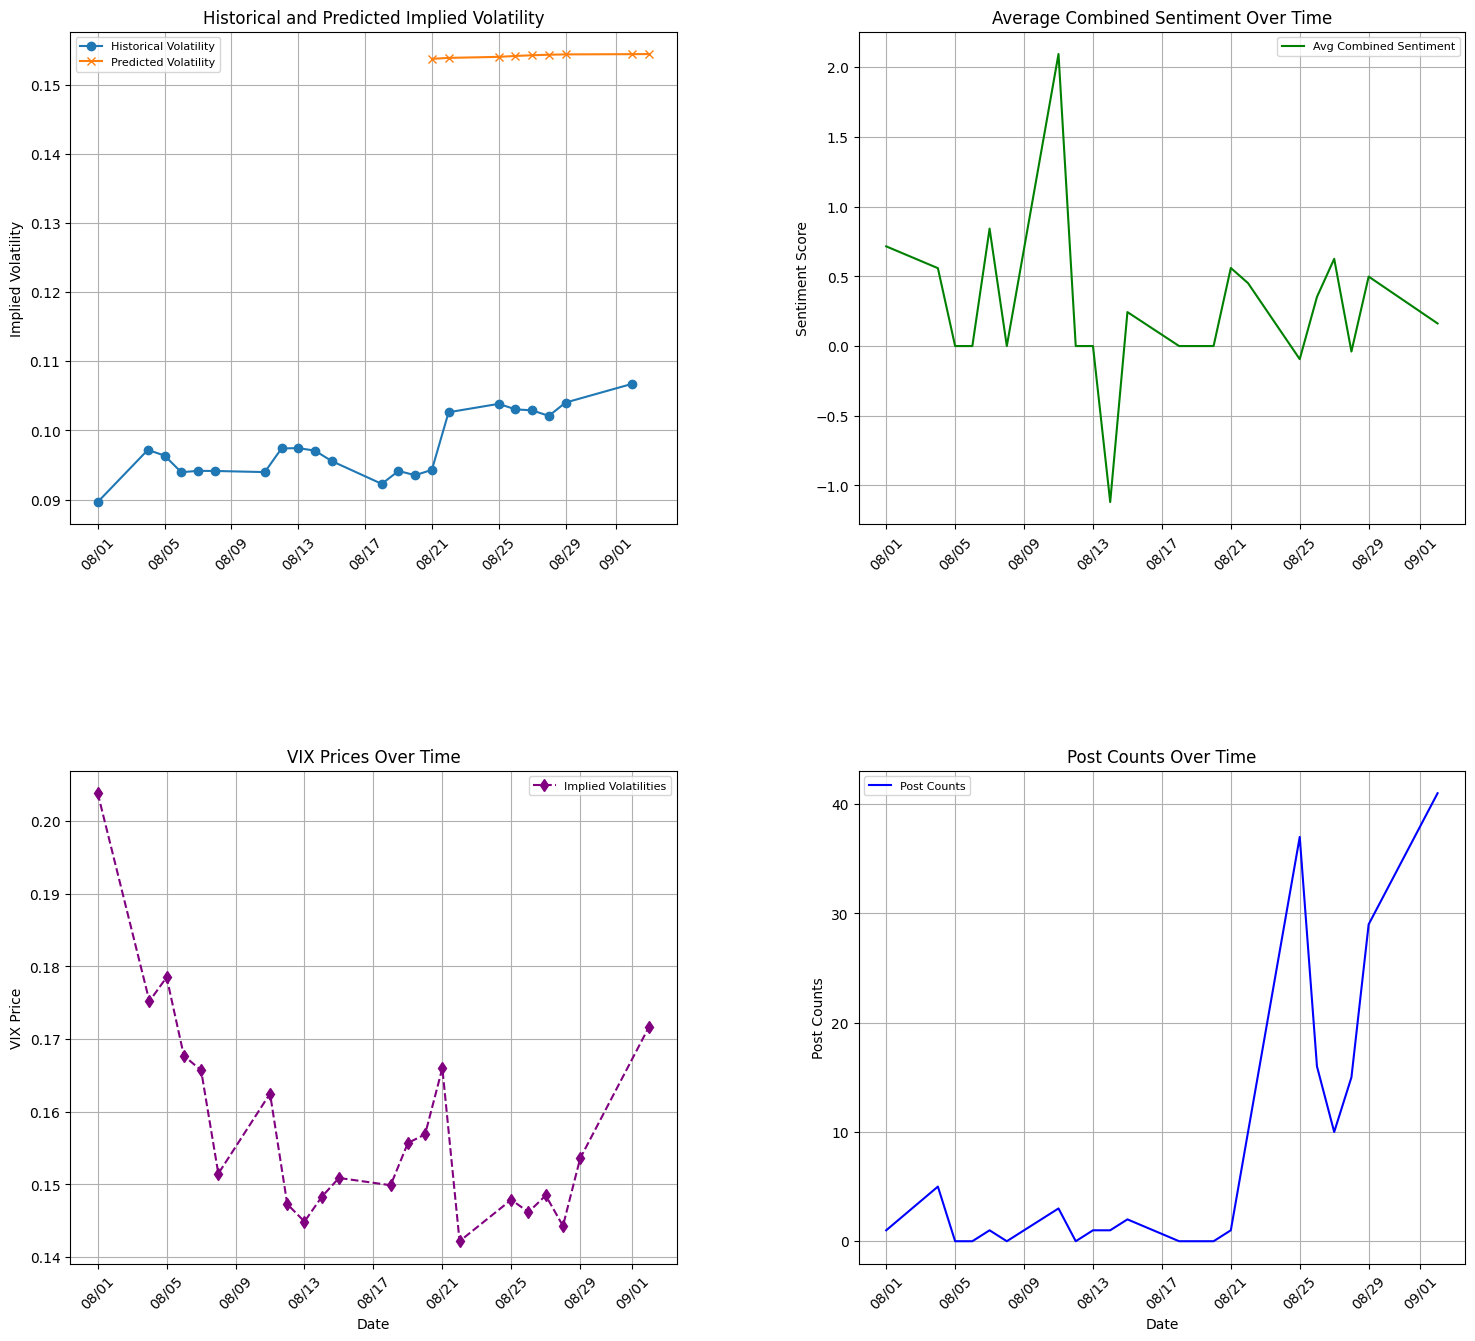

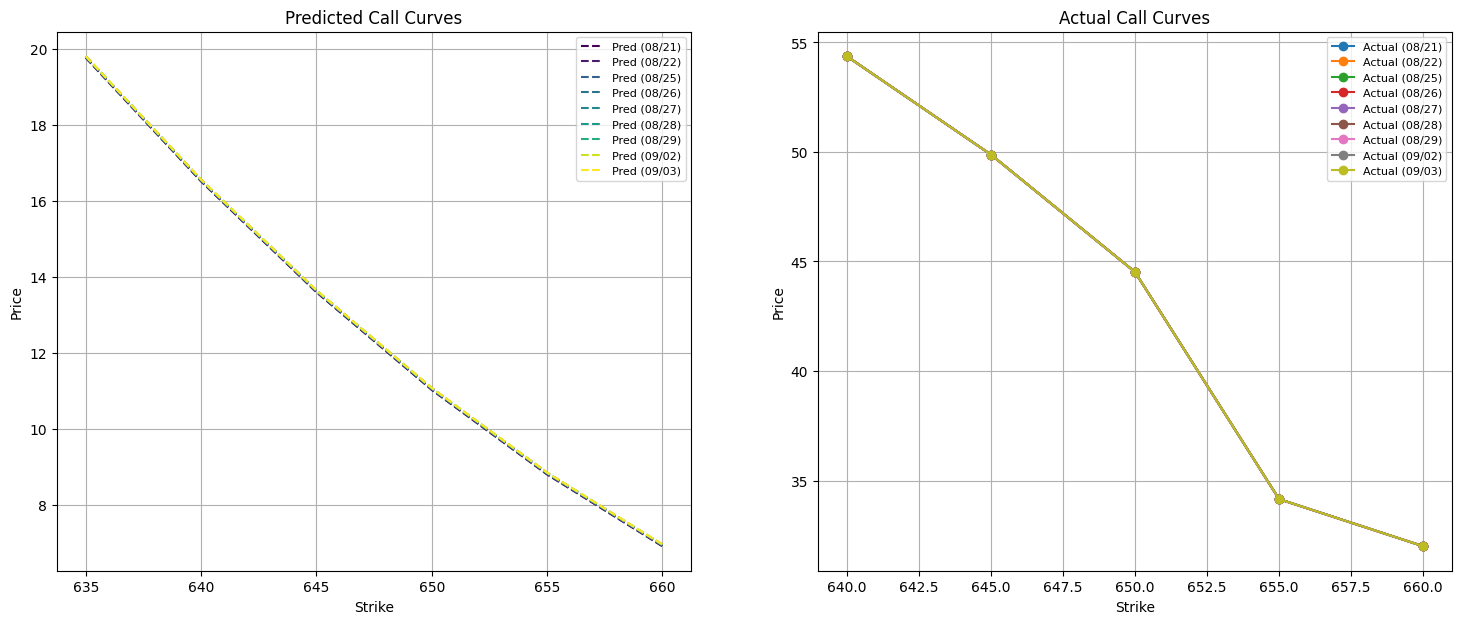

Correlation Matrix:
                            Historical Volatility  VIX Prices  \
Historical Volatility                    1.000000   -0.430757   
VIX Prices                              -0.430757    1.000000   
Average Combined Sentiment              -0.115875    0.309343   
Post Counts                              0.841667   -0.126528   

                            Average Combined Sentiment  Post Counts  
Historical Volatility                        -0.115875     0.841667  
VIX Prices                                    0.309343    -0.126528  
Average Combined Sentiment                    1.000000    -0.013353  
Post Counts                                  -0.013353     1.000000  
Metrics between predicted and actual option prices:
Correlation: 0.9793
Root Mean Squared Error (RMSE): 32.0450
Mean Absolute Percentage Error (MAPE): 73.98%


In [222]:
runner = VolatilityAnalysisRunner(json_file=r"data/sentiment_prev_full_month.json")
runner.run()

### Code used to create the data frame that included stock/volatility data and Google RSS Feed Sentiment data of 5 stocks over the past year (Currently commented out)

In [223]:
def closest_monday(date):
    # Check if the current date is not Monday (0 is Monday in weekday())
    days_to_subtract = date.weekday()  # 0 for Monday, ..., 6 for Sunday
    return date - timedelta(days=days_to_subtract)

In [224]:
DEFAULT_HEADERS = {
    "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                   "AppleWebKit/537.36 (KHTML, like Gecko) "
                   "Chrome/124.0 Safari/537.36"),
    "Accept": "application/rss+xml, application/xml;q=0.9, */*;q=0.8",
    "Connection": "close",
}

# Try multiple locales/regions to broaden coverage
NEWS_REGIONS = ["US:en", "GB:en", "CA:en", "AU:en", "IN:en"]

# Optional ticker -> alias map to expand queries
QUERY_SYNONYMS = {
    "META": ["Meta Platforms", "Facebook"],
    "TSM": ["TSMC", "Taiwan Semiconductor", "Taiwan Semiconductor Manufacturing Company"],
    "BBIO": ["BridgeBio", "BridgeBio Pharma", "Bridge Bio Pharma"],
    "RCKT": ["Rocket Pharmaceuticals", "Rocket Pharma"],
    "AMRX": ["Amneal Pharmaceuticals", "Amneal Pharma"],
}

def _parse_ceid(ceid: str):
    """
    ceid like 'US:en' -> (hl, gl, ceid)
    """
    try:
        country, lang = ceid.split(":")
        gl = country.upper()
        # Best effort HL locale: en-US, en-GB, etc.
        lang = lang.lower()
        if gl == "US":
            hl = f"{lang}-{gl}"
        else:
            # not always perfect, but improves diversity (e.g., en-GB)
            hl = f"{lang}-{gl}"
        return hl, gl, ceid
    except Exception:
        return "en-US", "US", "US:en"

def _normalize_title_key(s: str) -> str:
    s = html.unescape(s or "")
    s = s.lower()
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"[\s\-\_\|\·\•\:\;\,\.\!\?\(\)\[\]\{\}\"'\u2019\u2018\u2013\u2014]+", " ", s)
    return s.strip()

def _entry_date(entry) -> datetime | None:
    tm = getattr(entry, "published_parsed", None) or getattr(entry, "updated_parsed", None)
    if tm:
        try:
            return datetime(*tm[:6])
        except Exception:
            pass
    for key in ("published", "updated"):
        val = getattr(entry, key, None)
        if val:
            pp = getattr(entry, f"{key}_parsed", None)
            if pp:
                try:
                    return datetime(*pp[:6])
                except Exception:
                    pass
    return None

def _clean_text(s: str) -> str:
    s = html.unescape(s or "")
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _safe_textblob_polarity(text: str) -> float:
    try:
        return float(TextBlob(text).sentiment.polarity)
    except Exception:
        return 0.0

def _expand_query_terms(query: str) -> list[str]:
    """
    Expand a single query into multiple variants to boost recall.
    - add quoted form
    - if query looks like a ticker, add aliases & 'stock' form
    """
    terms = {query, f'"{query}"'}
    q_up = query.strip().upper()
    if 1 <= len(q_up) <= 5 and q_up.isalnum():
        # treat like a ticker
        terms.add(f"{q_up} stock")
        for alias in QUERY_SYNONYMS.get(q_up, []):
            terms.add(alias)
            terms.add(f'"{alias}"')
    return list(terms)

def fetch_google_news_items(query: str, start_date: str, end_date: str,
                            ceids: list[str] = NEWS_REGIONS, timeout=10, sleep_seconds=0.25) -> list[dict]:
    """
    Fetch Google News RSS entries for multiple regions and locally filter to [start_date, end_date].
    Returns list of dicts: {'date': date, 'title': ..., 'summary': ..., 'text': ..., 'ceid': ceid}
    """
    start_dt = datetime.strptime(start_date, "%Y-%m-%d").date()
    end_dt   = datetime.strptime(end_date,   "%Y-%m-%d").date()
    terms = _expand_query_terms(query)

    seen = set()
    items = []

    for ceid in ceids:
        hl, gl, ceid_val = _parse_ceid(ceid)
        for term in terms:
            q = urllib.parse.quote_plus(term)
            rss_url = f"https://news.google.com/rss/search?q={q}&hl={hl}&gl={gl}&ceid={ceid_val}"
            try:
                resp = requests.get(rss_url, headers=DEFAULT_HEADERS, timeout=timeout)
                resp.raise_for_status()
            except Exception:
                time.sleep(sleep_seconds)
                continue

            feed = feedparser.parse(resp.content)
            entries = getattr(feed, "entries", []) or []
            for e in entries:
                dt = _entry_date(e)
                if not dt:
                    continue
                d = dt.date()
                if d < start_dt or d > end_dt:
                    continue

                title = _clean_text(getattr(e, "title", ""))
                summary = _clean_text(getattr(e, "summary", "") or getattr(e, "description", ""))
                text = f"{title}. {summary}".strip() if len(summary) >= 15 else title
                if not text:
                    continue

                key = (_normalize_title_key(title), d)  # dedup by (title, day)
                if key in seen:
                    continue
                seen.add(key)

                items.append({
                    "date": d,
                    "ceid": ceid_val,
                    "title": title,
                    "summary": summary,
                    "text": text,
                })
            time.sleep(sleep_seconds)  # be gentle
    return items


In [225]:
import urllib.parse, html, re, requests, feedparser

def _clean_text(s: str) -> str:
    s = html.unescape(s or "")
    s = re.sub(r"<[^>]+>", " ", s)     # strip HTML tags
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _entry_date(entry) -> datetime | None:
    # Try structured dates first
    tm = getattr(entry, "published_parsed", None) or getattr(entry, "updated_parsed", None)
    if tm:
        return datetime(*tm[:6])
    # Fallback: try string fields
    for key in ("published", "updated"):
        val = getattr(entry, key, None)
        if val:
            try:
                # feedparser exposes a helper, but datetime.fromisoformat may fail on RFC2822
                # Let feedparser’s parsed date be the source of truth when possible.
                return datetime(*entry.get(f"{key}_parsed")[:6])
            except Exception:
                pass
    return None

def _safe_textblob_polarity(text: str) -> float:
    try:
        return float(TextBlob(text).sentiment.polarity)
    except Exception:
        return 0.0

def get_sentiment(query: str, start_date: str, end_date: str, *, debug=False) -> float:
    """
    Multi-region, multi-variant Google News RSS sentiment (TextBlob only).
    Returns average polarity in [-1, 1]. 0.0 if nothing matched.
    """
    items = fetch_google_news_items(query, start_date, end_date)
    if debug:
        print(f"[NEWS] query='{query}' {start_date}→{end_date} | items={len(items)}")

    if not items:
        return 0.0

    scores = [_safe_textblob_polarity(it["text"]) for it in items]
    return float(sum(scores) / len(scores)) if scores else 0.0

In [226]:
def create_weekly_dataframe(start_date, end_date):
    # Ensure start_date and end_date are in datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Generate a date range from start_date to end_date in weekly intervals
    date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')  # Weekly frequency, starting on Monday
    
    # Create a DataFrame with the date range as the index
    df = pd.DataFrame(index=date_range)
    
    return df

In [227]:
def add_stock_prices(df, ticker):
    start_date = df.index.min()  # Earliest date in your DataFrame
    end_date = df.index.max()    # Latest date in your DataFrame
    price_tag = ticker + ' Price'
    roc_tag = ticker + ' ROC'
    stock_data = yf.download(ticker, start=start_date, end=(end_date + timedelta(days=1)))
    stock_data = stock_data['Close'].resample('D').ffill() 
    stock_data.index = stock_data.index.tz_localize(None) 
    df[price_tag] = stock_data.reindex(df.index)
    # Forward return: Week N row contains return from Week N to Week N+1
    # This aligns with sentiment from Week N predicting Week N+1 return
    # Formula: (next_period_price / current_price - 1) * 100
    df[roc_tag] = (df[price_tag].shift(-1) / df[price_tag] - 1) * 100

def add_SPY(df):
    start_date = df.index.min()  # Earliest date in your DataFrame
    end_date = df.index.max()    # Latest date in your DataFrame
    price_tag = 'SPY Price'
    roc_tag = 'SPY ROC'
    stock_data = yf.download('SPY', start=start_date, end=(end_date + timedelta(days=1)))
    stock_data = stock_data['Close'].resample('D').ffill() 
    stock_data.index = stock_data.index.tz_localize(None) 
    df[price_tag] = stock_data.reindex(df.index)
    # Forward return: Week N row contains return from Week N to Week N+1
    # This aligns with sentiment from Week N predicting Week N+1 return
    # Formula: (next_period_price / current_price - 1) * 100
    df[roc_tag] = (df[price_tag].shift(-1) / df[price_tag] - 1) * 100

In [228]:
def add_weekly_stock_volatility(df, ticker, window=7):
    """
    Populate a weekly DataFrame with the stock's volatility.

    Parameters:
    - df: Weekly DataFrame with a datetime index
    - ticker: Stock ticker symbol as a string
    - window: Rolling window size (in days) for volatility calculation
    """
    # Determine the start and end dates from the weekly DataFrame
    start_date = df.index.min()
    end_date = df.index.max()

    # Download historical stock data
    stock_data = yf.download(ticker, start=start_date, end=(end_date + timedelta(days=1)))

    # Fill missing values in stock prices
    stock_data['Close'] = stock_data['Close'].ffill().bfill()

    # Calculate daily returns
    stock_data['Daily Return'] = stock_data['Close'].pct_change()

    # Calculate rolling volatility (standard deviation of daily returns)
    stock_data['Volatility'] = stock_data['Daily Return'].rolling(window=window, min_periods=1).std() * 100  # Convert to percentage

    # Align the volatility data with the weekly DataFrame
    stock_data.index = stock_data.index.tz_localize(None)  # Remove timezone info
    weekly_volatility = stock_data['Volatility'].resample('W-MON').last()  # Use the last volatility value for each week

    # Add the volatility data to the weekly DataFrame
    volatility_tag = ticker + ' Volatility'
    df[volatility_tag] = weekly_volatility.reindex(df.index).fillna(method='ffill')  # Forward fill missing values

    return df

In [229]:
def populate_weekly_sentiment(df, ticker, query):
    """
    Populates a DataFrame with weekly sentiment scores for a specified stock ticker based on news articles.

    Parameters:
        df (pandas.DataFrame): A DataFrame with a DatetimeIndex where each row represents a Monday, 
                               and columns to be updated with sentiment data.
        ticker (str): The stock ticker symbol for which sentiment is being calculated.
        query (str): The search query to use for fetching news articles related to the stock.

    Returns:
        pandas.DataFrame: The input DataFrame with an additional column containing the weekly sentiment scores 
                          for the specified stock ticker.

    Process:
        1. For each Monday in the DataFrame's index:
            - Define the start and end dates for the week (Monday to Sunday).
            - Fetch news articles for the query and date range using the `get_sentiment` function.
            - Calculate and store the average sentiment score for the week.
        2. Add the sentiment scores as a new column named "<ticker> Sentiment" in the DataFrame.

    Example:
        >>> df = pd.DataFrame(index=pd.date_range(start="2024-01-01", periods=4, freq="W-MON"))
        >>> df = populate_weekly_sentiment(df, "AAPL", "Apple Inc")
        >>> print(df)
                       AAPL Sentiment
        2024-01-01           0.12
        2024-01-08           0.10
        2024-01-15          -0.05
        2024-01-22           0.20

    Note:
        - The `get_sentiment` function must be defined and accessible for this function to work.
        - Ensure the index of the input DataFrame contains only Mondays to avoid mismatches in weekly calculations.
    """
    # Initialize a list to hold sentiment scores
    sentiment_scores = []
    count = 1
    
    # Loop over each Monday in the index
    for monday in df.index:
        if count % 10 == 0:
            print(f'Week {count} sentiment added for {ticker}')
        
        # Define the date range for the week (Monday to Sunday)
        week_start = monday
        week_end = monday + timedelta(days=6)

        # Calculate sentiment for the week
        sentiment = get_sentiment(query, week_start.strftime("%Y-%m-%d"), week_end.strftime("%Y-%m-%d"))
        
        # Append the sentiment score to the list
        sentiment_scores.append(sentiment)
        count += 1
    
    # Assign the sentiment scores to a new column in the DataFrame
    df[ticker + ' Sentiment'] = sentiment_scores
    return df

In [230]:
def populate_weekly_volume(df, ticker, query):
    """
    Weekly article counts across multiple regions & query variants.
    """
    volumes = []
    count = 1
    for monday in df.index:
        if count % 10 == 0:
            print(f'Week {count} volume added for {ticker}')
        week_start = monday
        week_end = monday + timedelta(days=6)

        items = fetch_google_news_items(
            query,
            week_start.strftime("%Y-%m-%d"),
            week_end.strftime("%Y-%m-%d"),
        )
        volumes.append(len(items))
        count += 1

    df[ticker + ' Article Volume'] = volumes
    return df


In [231]:
def populate_sentiment_and_price(df, ticker, query):
    populate_weekly_sentiment(df, ticker, query)
    add_stock_prices(df, ticker)

In [232]:
def generate_df(tags, start_date, end_date):
    df = create_weekly_dataframe(start_date, end_date)
    for tag in tags:
        ticker = tag[0]
        query = tag[1]
        populate_sentiment_and_price(df, ticker, query)
        add_SPY(df)
    return df

In [233]:
# DATA GENERATION CELL - COMMENTED OUT (using existing weekly_stock_data.csv)
# start_date = '2024-06-01'
# end_date = pd.Timestamp.today()
# tags = [('BBIO', 'Bridge Bio Pharma Inc'), ('RCKT', 'Rocket Pharmaceuticals Inc'), 
#         ('AMRX', 'Amneal Pharmaceuticals Inc'), ('META', 'META'), ('TSM', 'Taiwan Semiconductor Manufacturing Company')]
# df = generate_df(tags, start_date, end_date)

# Load existing data instead
df = pd.read_csv('data/weekly_stock_data.csv', index_col=0, parse_dates=True)
tags = [('BBIO', 'Bridge Bio Pharma Inc'), ('RCKT', 'Rocket Pharmaceuticals Inc'), 
        ('AMRX', 'Amneal Pharmaceuticals Inc'), ('META', 'META'), ('TSM', 'Taiwan Semiconductor Manufacturing Company')]
tickers = [tag[0] for tag in tags]

In [234]:
# DATA GENERATION CELL - COMMENTED OUT (volatility already in weekly_stock_data.csv)
# tickers = [tag[0] for tag in tags]
# for ticker in tickers:
#     add_weekly_stock_volatility(df, ticker)

In [235]:
# DATA GENERATION CELL - COMMENTED OUT (volume already in weekly_stock_data.csv)
# for tag in tags:
#     populate_weekly_volume(df, tag[0], tag[1])

In [236]:
# DATA GENERATION CELL - COMMENTED OUT (weekly_stock_data.csv already exists)
# df.to_csv('weekly_stock_data.csv')

### Creating tags with tickers and actual company names for data exploration

### Creating functions to plot certain values of stocks over time for analysis

In [237]:
def plot_sentiment_vs_roc(df, tickers):
    """
    This function takes in a DataFrame `df` and a list of tickers, and generates a plot for each ticker
    showing the Rate of Change (ROC) and sentiment over time.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data for each ticker, including columns for ROC and sentiment.
    - tickers (list): A list of tickers to generate the plots for.

    Returns:
    - None: Displays the plots for each ticker.
    """
    
    # Set up the plot layout
    fig, axes = plt.subplots(len(tickers), 1, figsize=(15, 5 * len(tickers)))
    
    # Loop through each ticker and create a plot
    for i, ticker in enumerate(tickers):
        sentiment_col = f'{ticker} Sentiment'
        roc_col = f'{ticker} ROC'
        
        # Create the first plot (for ROC)
        ax1 = axes[i]
        ax1.plot(df.index, df[roc_col] - df['SPY ROC'], color='blue', label='ROC', alpha=0.7)
        ax1.set_title(f'{ticker} ROC and Sentiment over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Rate of Change (%)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        # Create the second y-axis (for Sentiment)
        ax2 = ax1.twinx()
        ax2.plot(df.index, df[sentiment_col], color='red', label='Sentiment', alpha=0.7)
        ax2.set_ylabel('Sentiment', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Add a legend for both axes
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

In [238]:
import matplotlib.pyplot as plt

def plot_sentiment_vs_price(df, tickers):
    """
    This function takes in a DataFrame `df` and a list of tickers, and generates a plot for each ticker
    showing the Rate of Change (ROC) and sentiment over time.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data for each ticker, including columns for ROC and sentiment.
    - tickers (list): A list of tickers to generate the plots for.

    Returns:
    - None: Displays the plots for each ticker.
    """
    
    # Set up the plot layout
    fig, axes = plt.subplots(len(tickers), 1, figsize=(15, 5 * len(tickers)))
    
    # Loop through each ticker and create a plot
    for i, ticker in enumerate(tickers):
        sentiment_col = f'{ticker} Sentiment'
        roc_col = f'{ticker} Price'
        
        # Create the first plot (for ROC)
        ax1 = axes[i]
        ax1.plot(df.index, df[roc_col], color='blue', label='ROC', alpha=0.7)
        ax1.set_title(f'{ticker} ROC and Sentiment over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        # Create the second y-axis (for Sentiment)
        ax2 = ax1.twinx()
        ax2.plot(df.index, df[sentiment_col], color='red', label='Sentiment', alpha=0.7)
        ax2.set_ylabel('Sentiment', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Add a legend for both axes
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

In [239]:
def plot_sentiment_vs_volatility(df, tickers):
    """
    This function takes in a DataFrame `df` and a list of tickers, and generates a plot for each ticker
    showing the Volatility and Sentiment over time.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data for each ticker, including columns for volatility and sentiment.
    - tickers (list): A list of tickers to generate the plots for.

    Returns:
    - None: Displays the plots for each ticker.
    """
    
    # Set up the plot layout
    fig, axes = plt.subplots(len(tickers), 1, figsize=(15, 5 * len(tickers)))
    
    # If only one ticker, ensure axes is treated as a list for consistency
    if len(tickers) == 1:
        axes = [axes]
    
    # Loop through each ticker and create a plot
    for i, ticker in enumerate(tickers):
        sentiment_col = f'{ticker} Sentiment'
        volatility_col = f'{ticker} Volatility'
        
        # Create the first plot (for Volatility)
        ax1 = axes[i]
        ax1.plot(df.index, df[volatility_col], color='blue', label='Volatility', alpha=0.7)
        ax1.set_title(f'{ticker} Volatility and Sentiment over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Volatility (%)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        # Create the second y-axis (for Sentiment)
        ax2 = ax1.twinx()
        ax2.plot(df.index, df[sentiment_col], color='red', label='Sentiment', alpha=0.7)
        ax2.set_ylabel('Sentiment', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Add a legend for both axes
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


In [240]:
def plot_volume_vs_volatility(df, tickers):
    """
    This function takes in a DataFrame `df` and a list of tickers, and generates a plot for each ticker
    showing the Volatility and Sentiment over time.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data for each ticker, including columns for volatility and sentiment.
    - tickers (list): A list of tickers to generate the plots for.

    Returns:
    - None: Displays the plots for each ticker.
    """
    
    # Set up the plot layout
    fig, axes = plt.subplots(len(tickers), 1, figsize=(15, 5 * len(tickers)))
    
    # If only one ticker, ensure axes is treated as a list for consistency
    if len(tickers) == 1:
        axes = [axes]
    
    # Loop through each ticker and create a plot
    for i, ticker in enumerate(tickers):
        volume_col = f'{ticker} Article Volume'
        volatility_col = f'{ticker} Volatility'
        
        # Create the first plot (for Volatility)
        ax1 = axes[i]
        ax1.plot(df.index, df[volume_col], color='blue', label='Article Volume', alpha=0.7)
        ax1.set_title(f'{ticker} Article Volume and Volatility over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Article Volume', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        # Create the second y-axis (for Sentiment)
        ax2 = ax1.twinx()
        ax2.plot(df.index, df[volatility_col], color='red', label='Volatility', alpha=0.7)
        ax2.set_ylabel('volatility', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Add a legend for both axes
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


### Plots are shown for all 5 stocks, detailing change of certain features over time

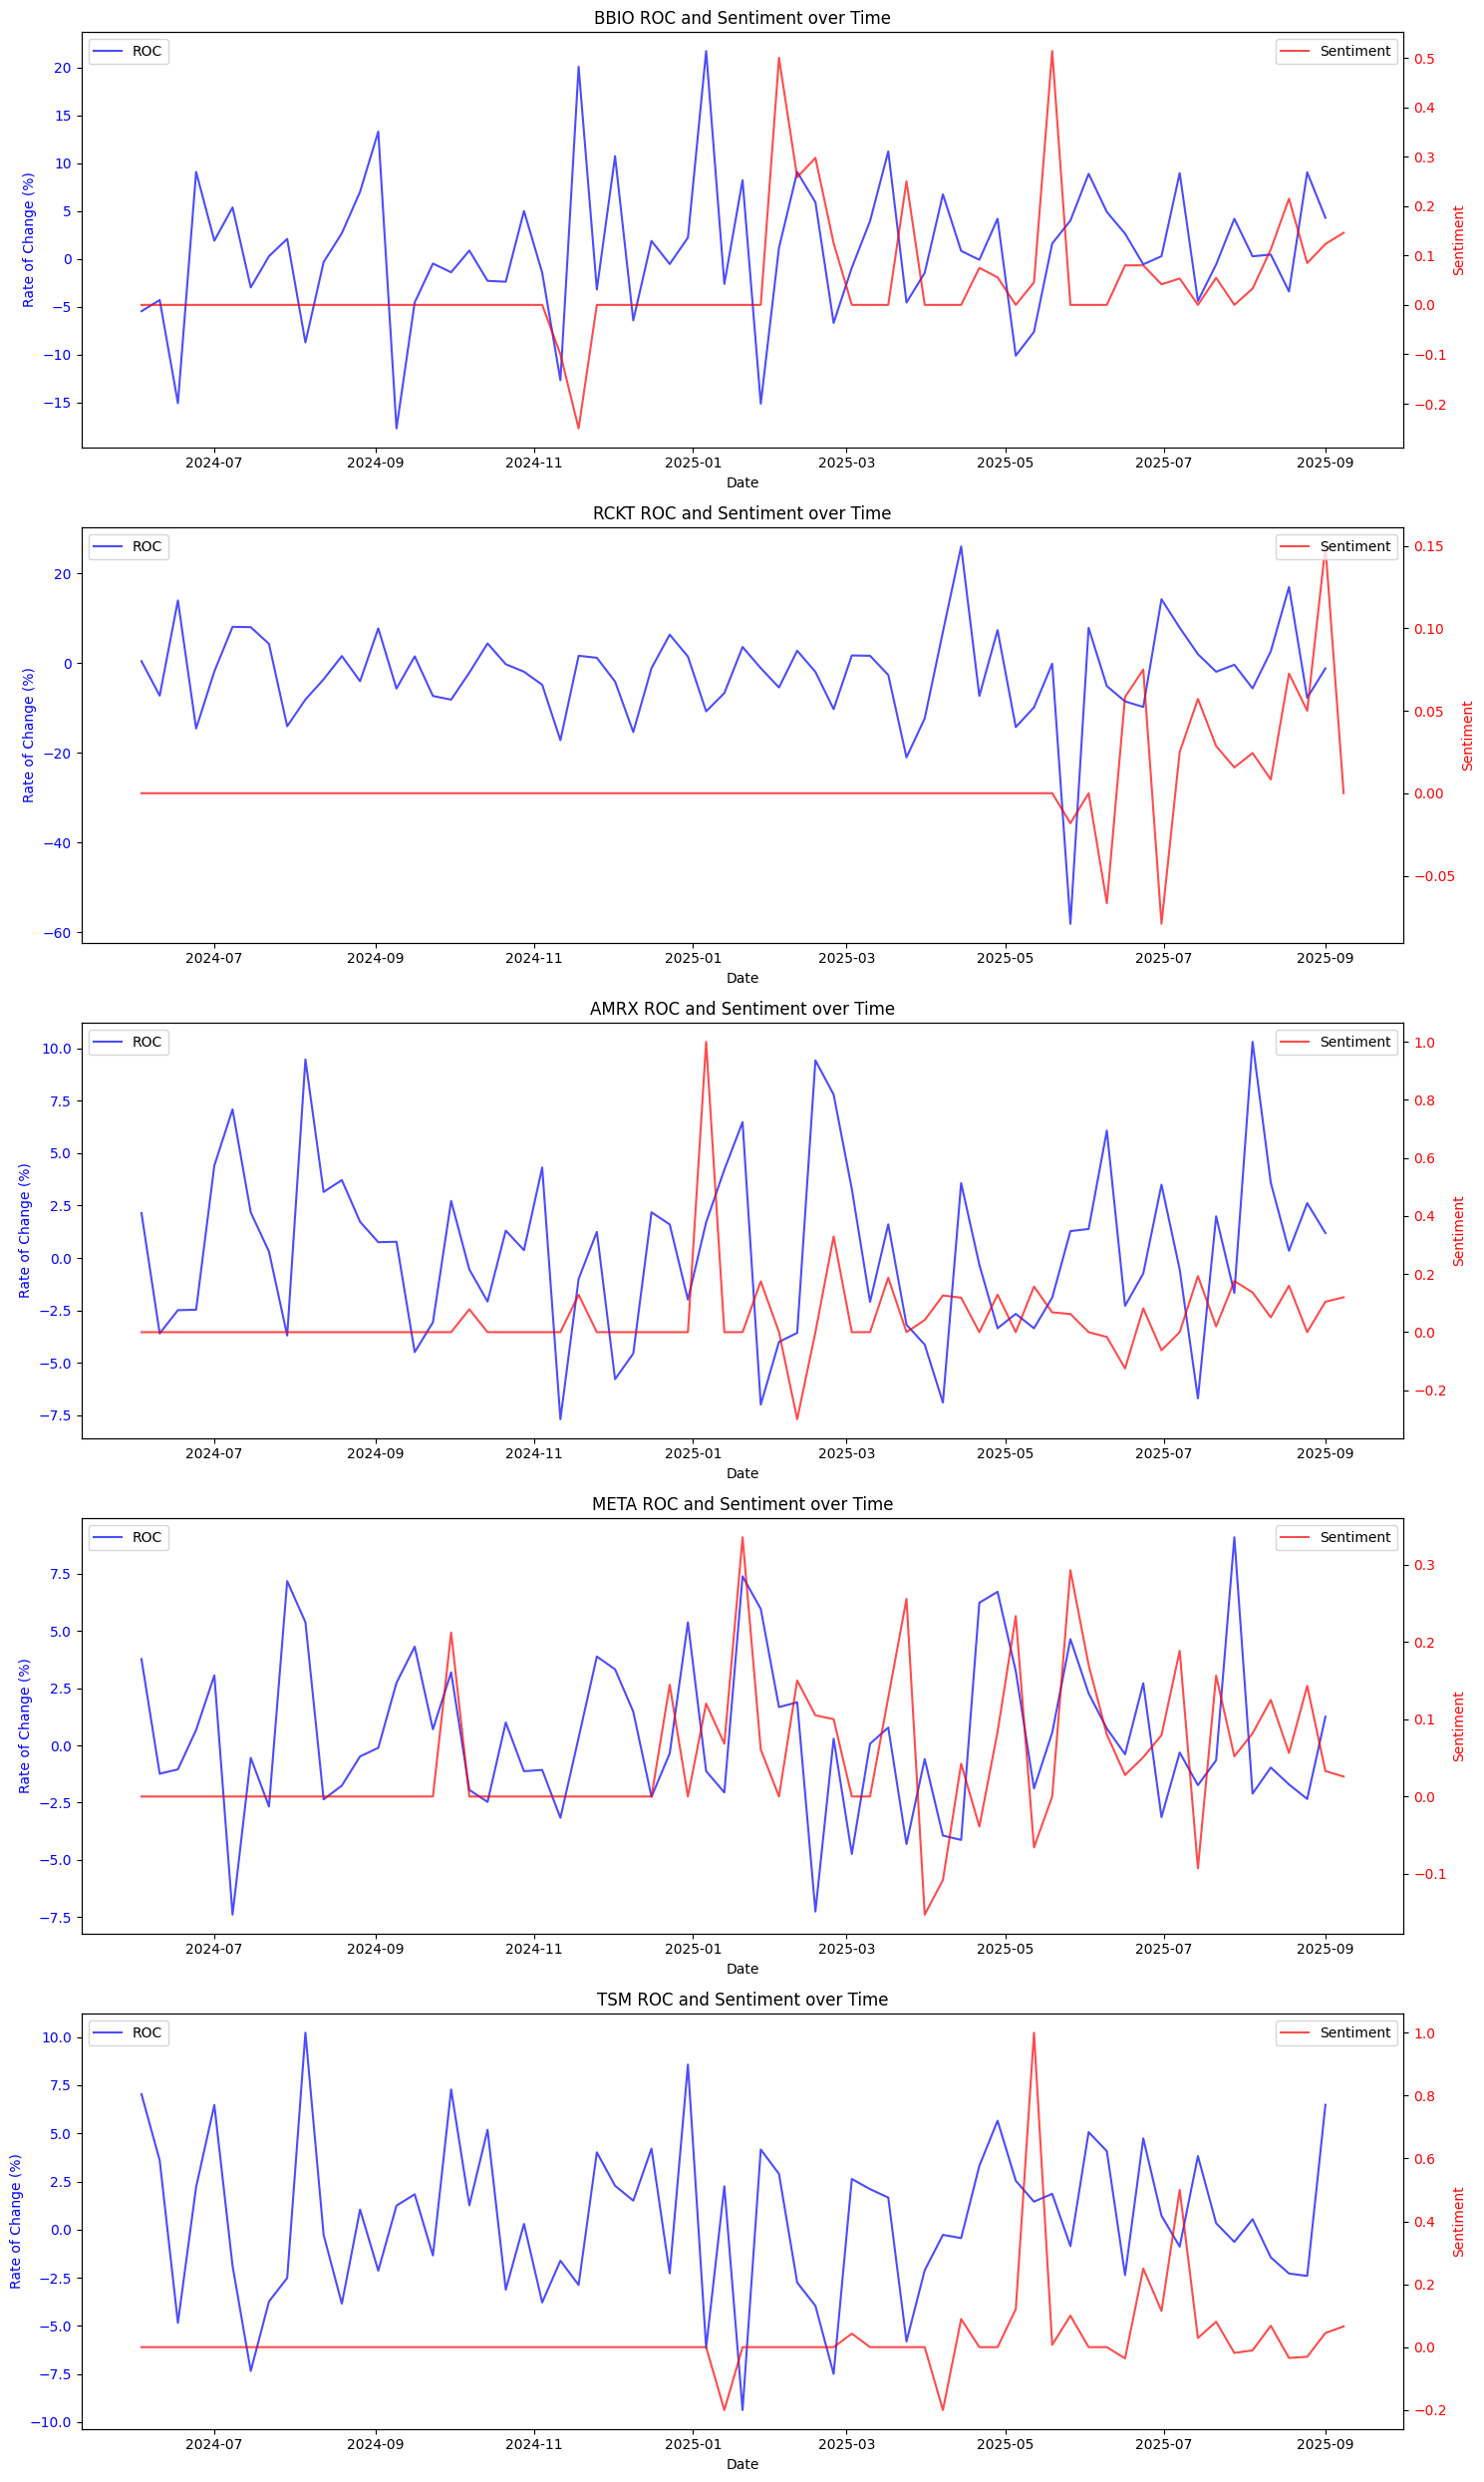

In [241]:
plt.rcParams["figure.figsize"] = (12, 6)  
plot_sentiment_vs_roc(df, tickers)

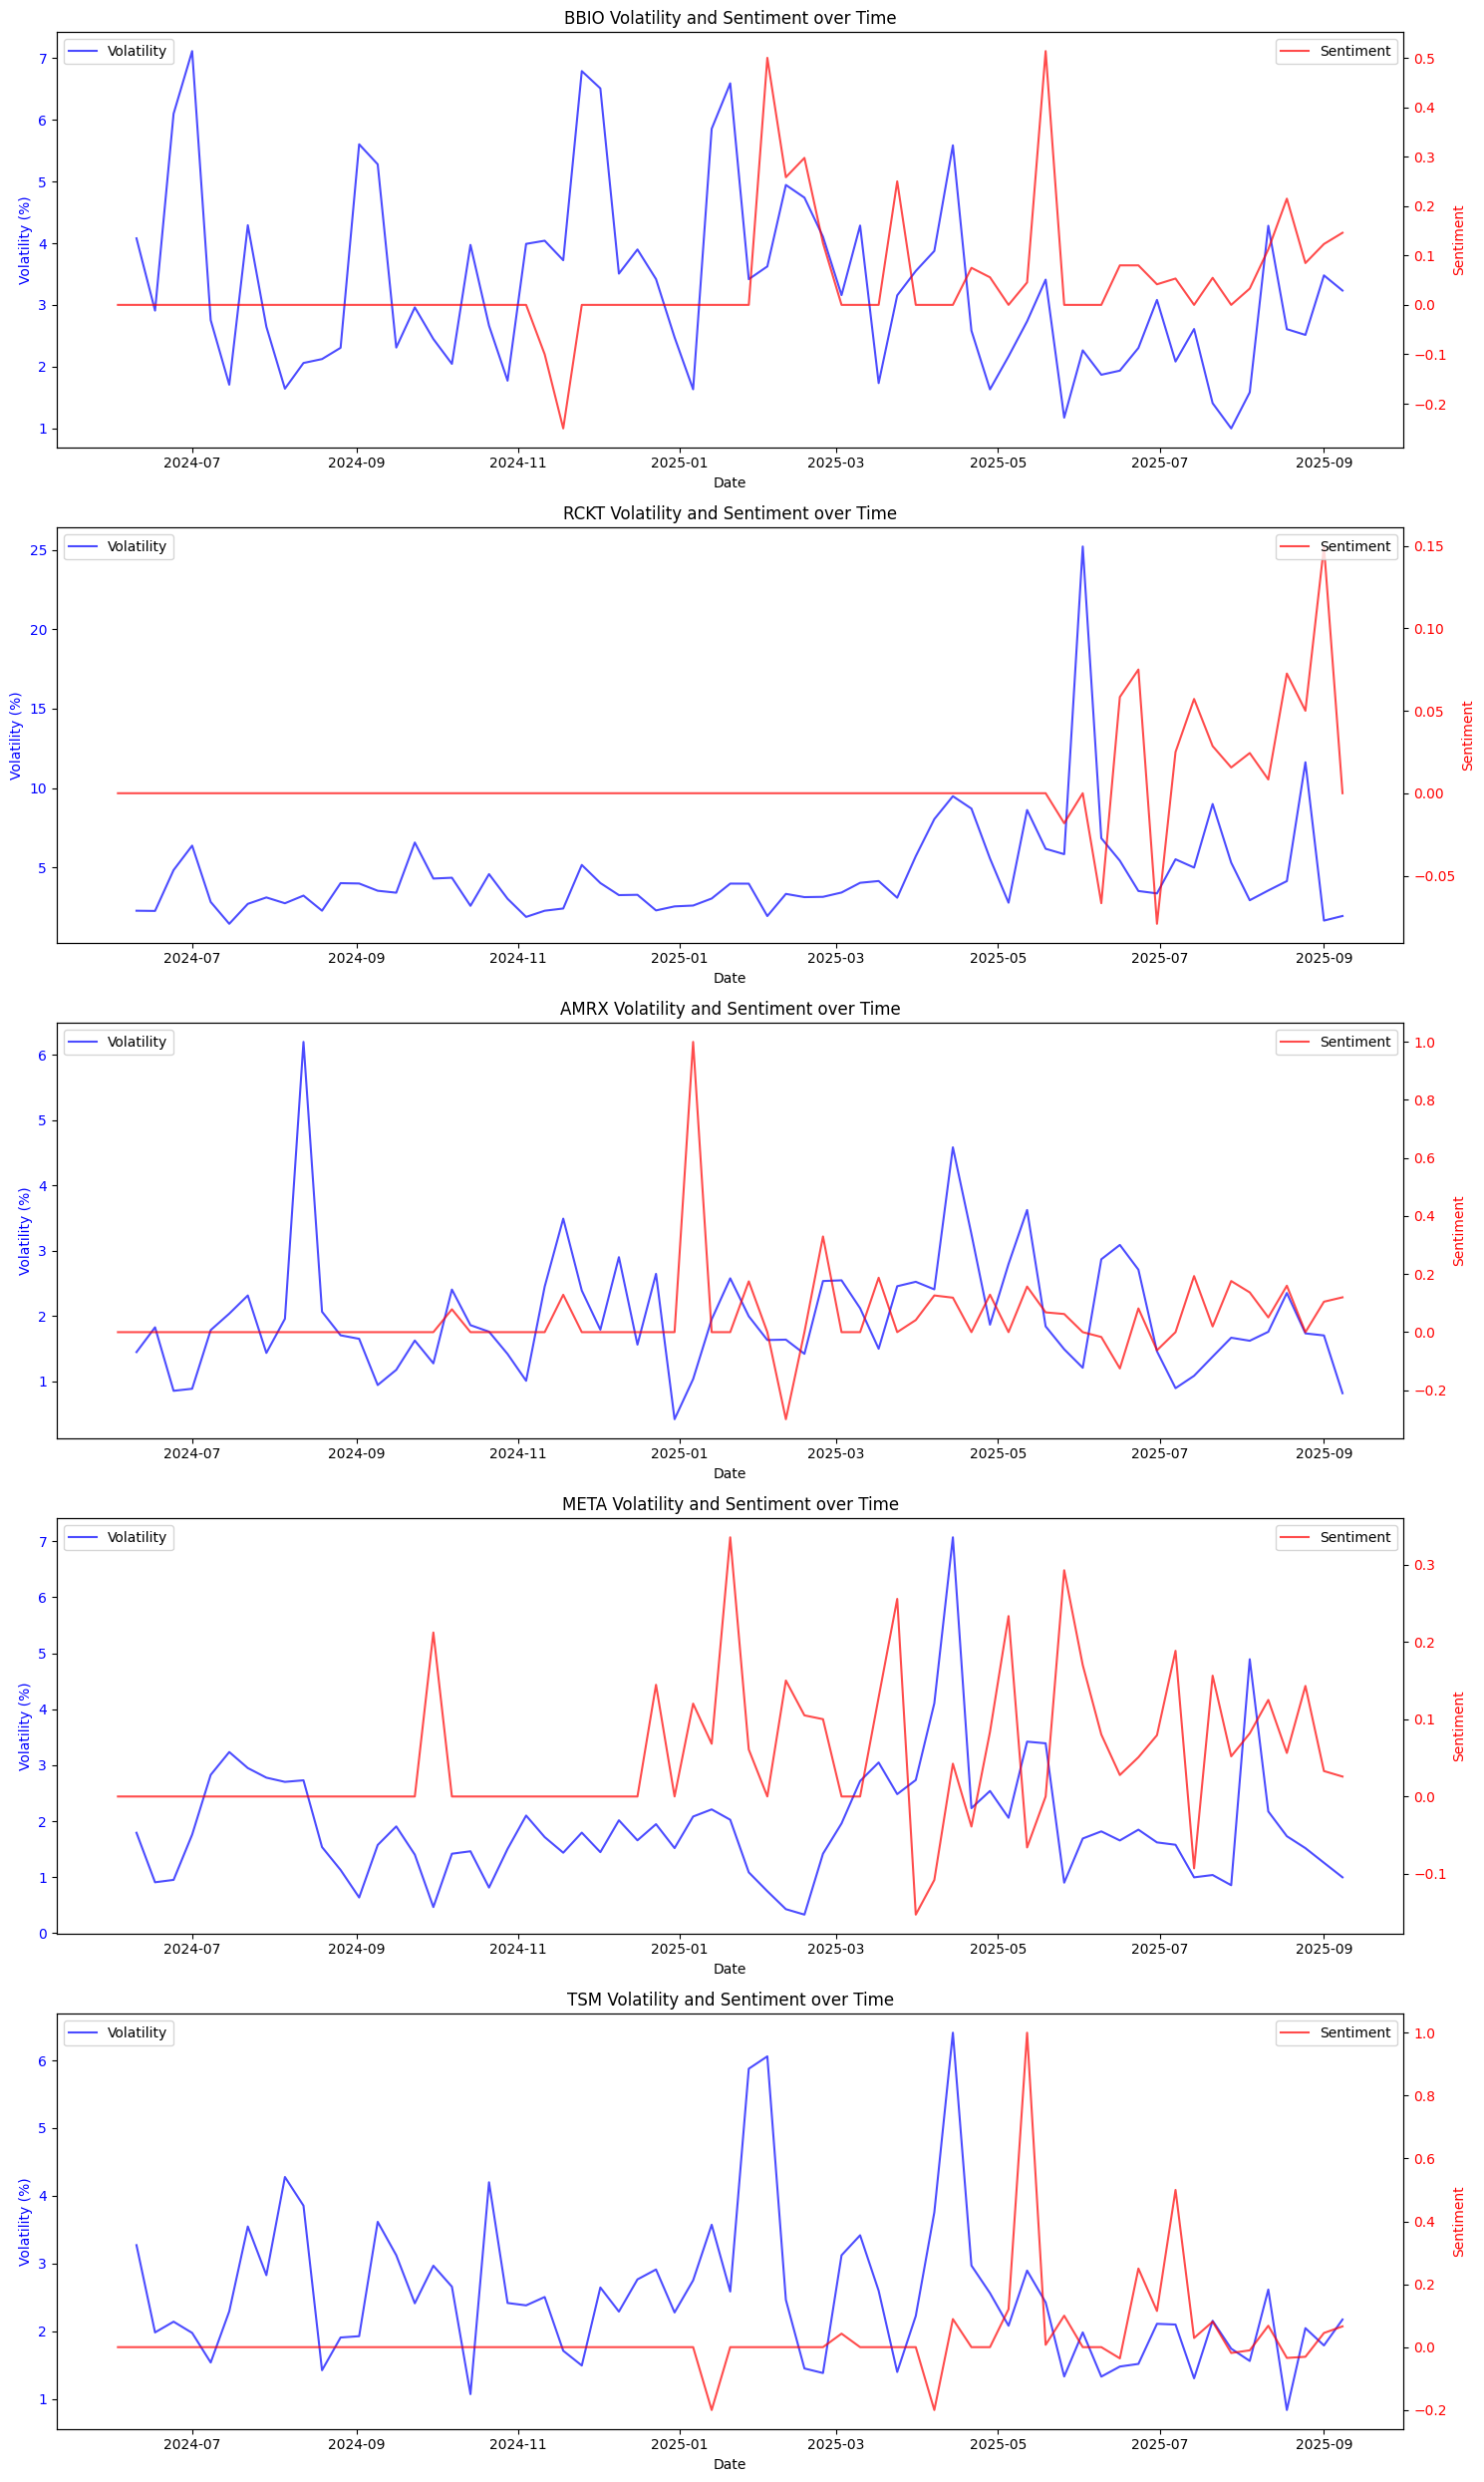

In [242]:
plot_sentiment_vs_volatility(df, tickers)

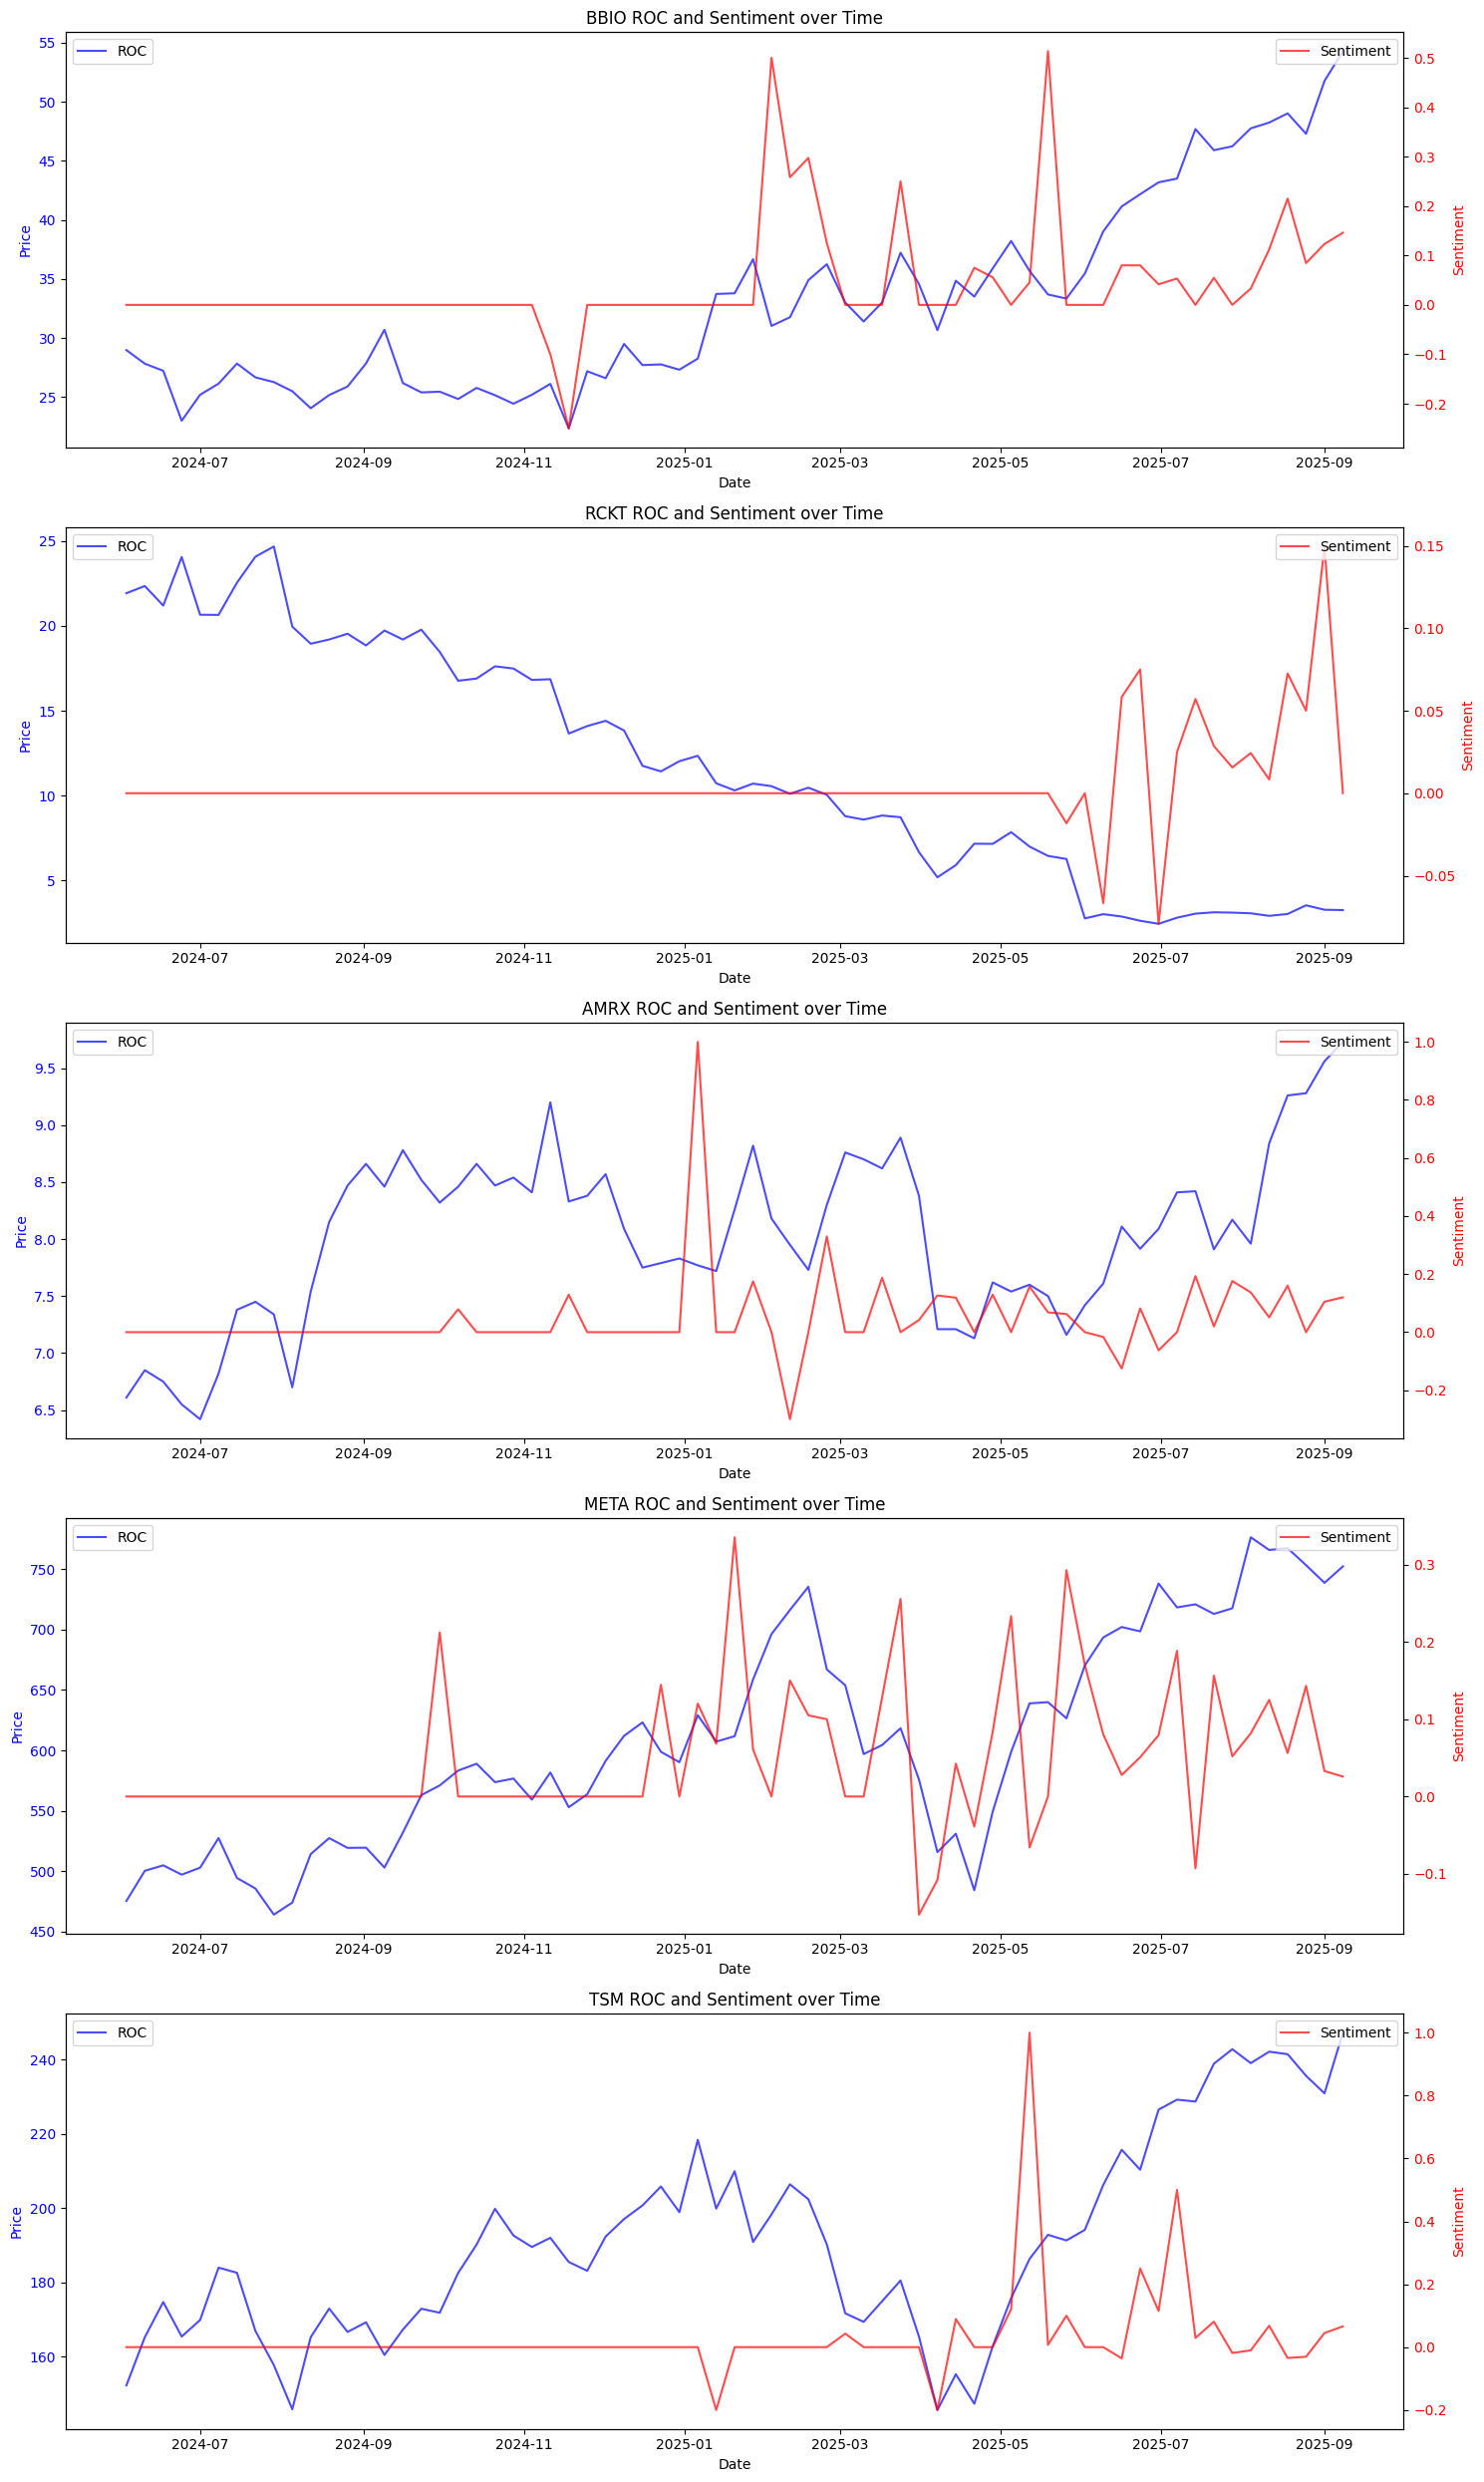

In [243]:
plot_sentiment_vs_price(df, tickers)

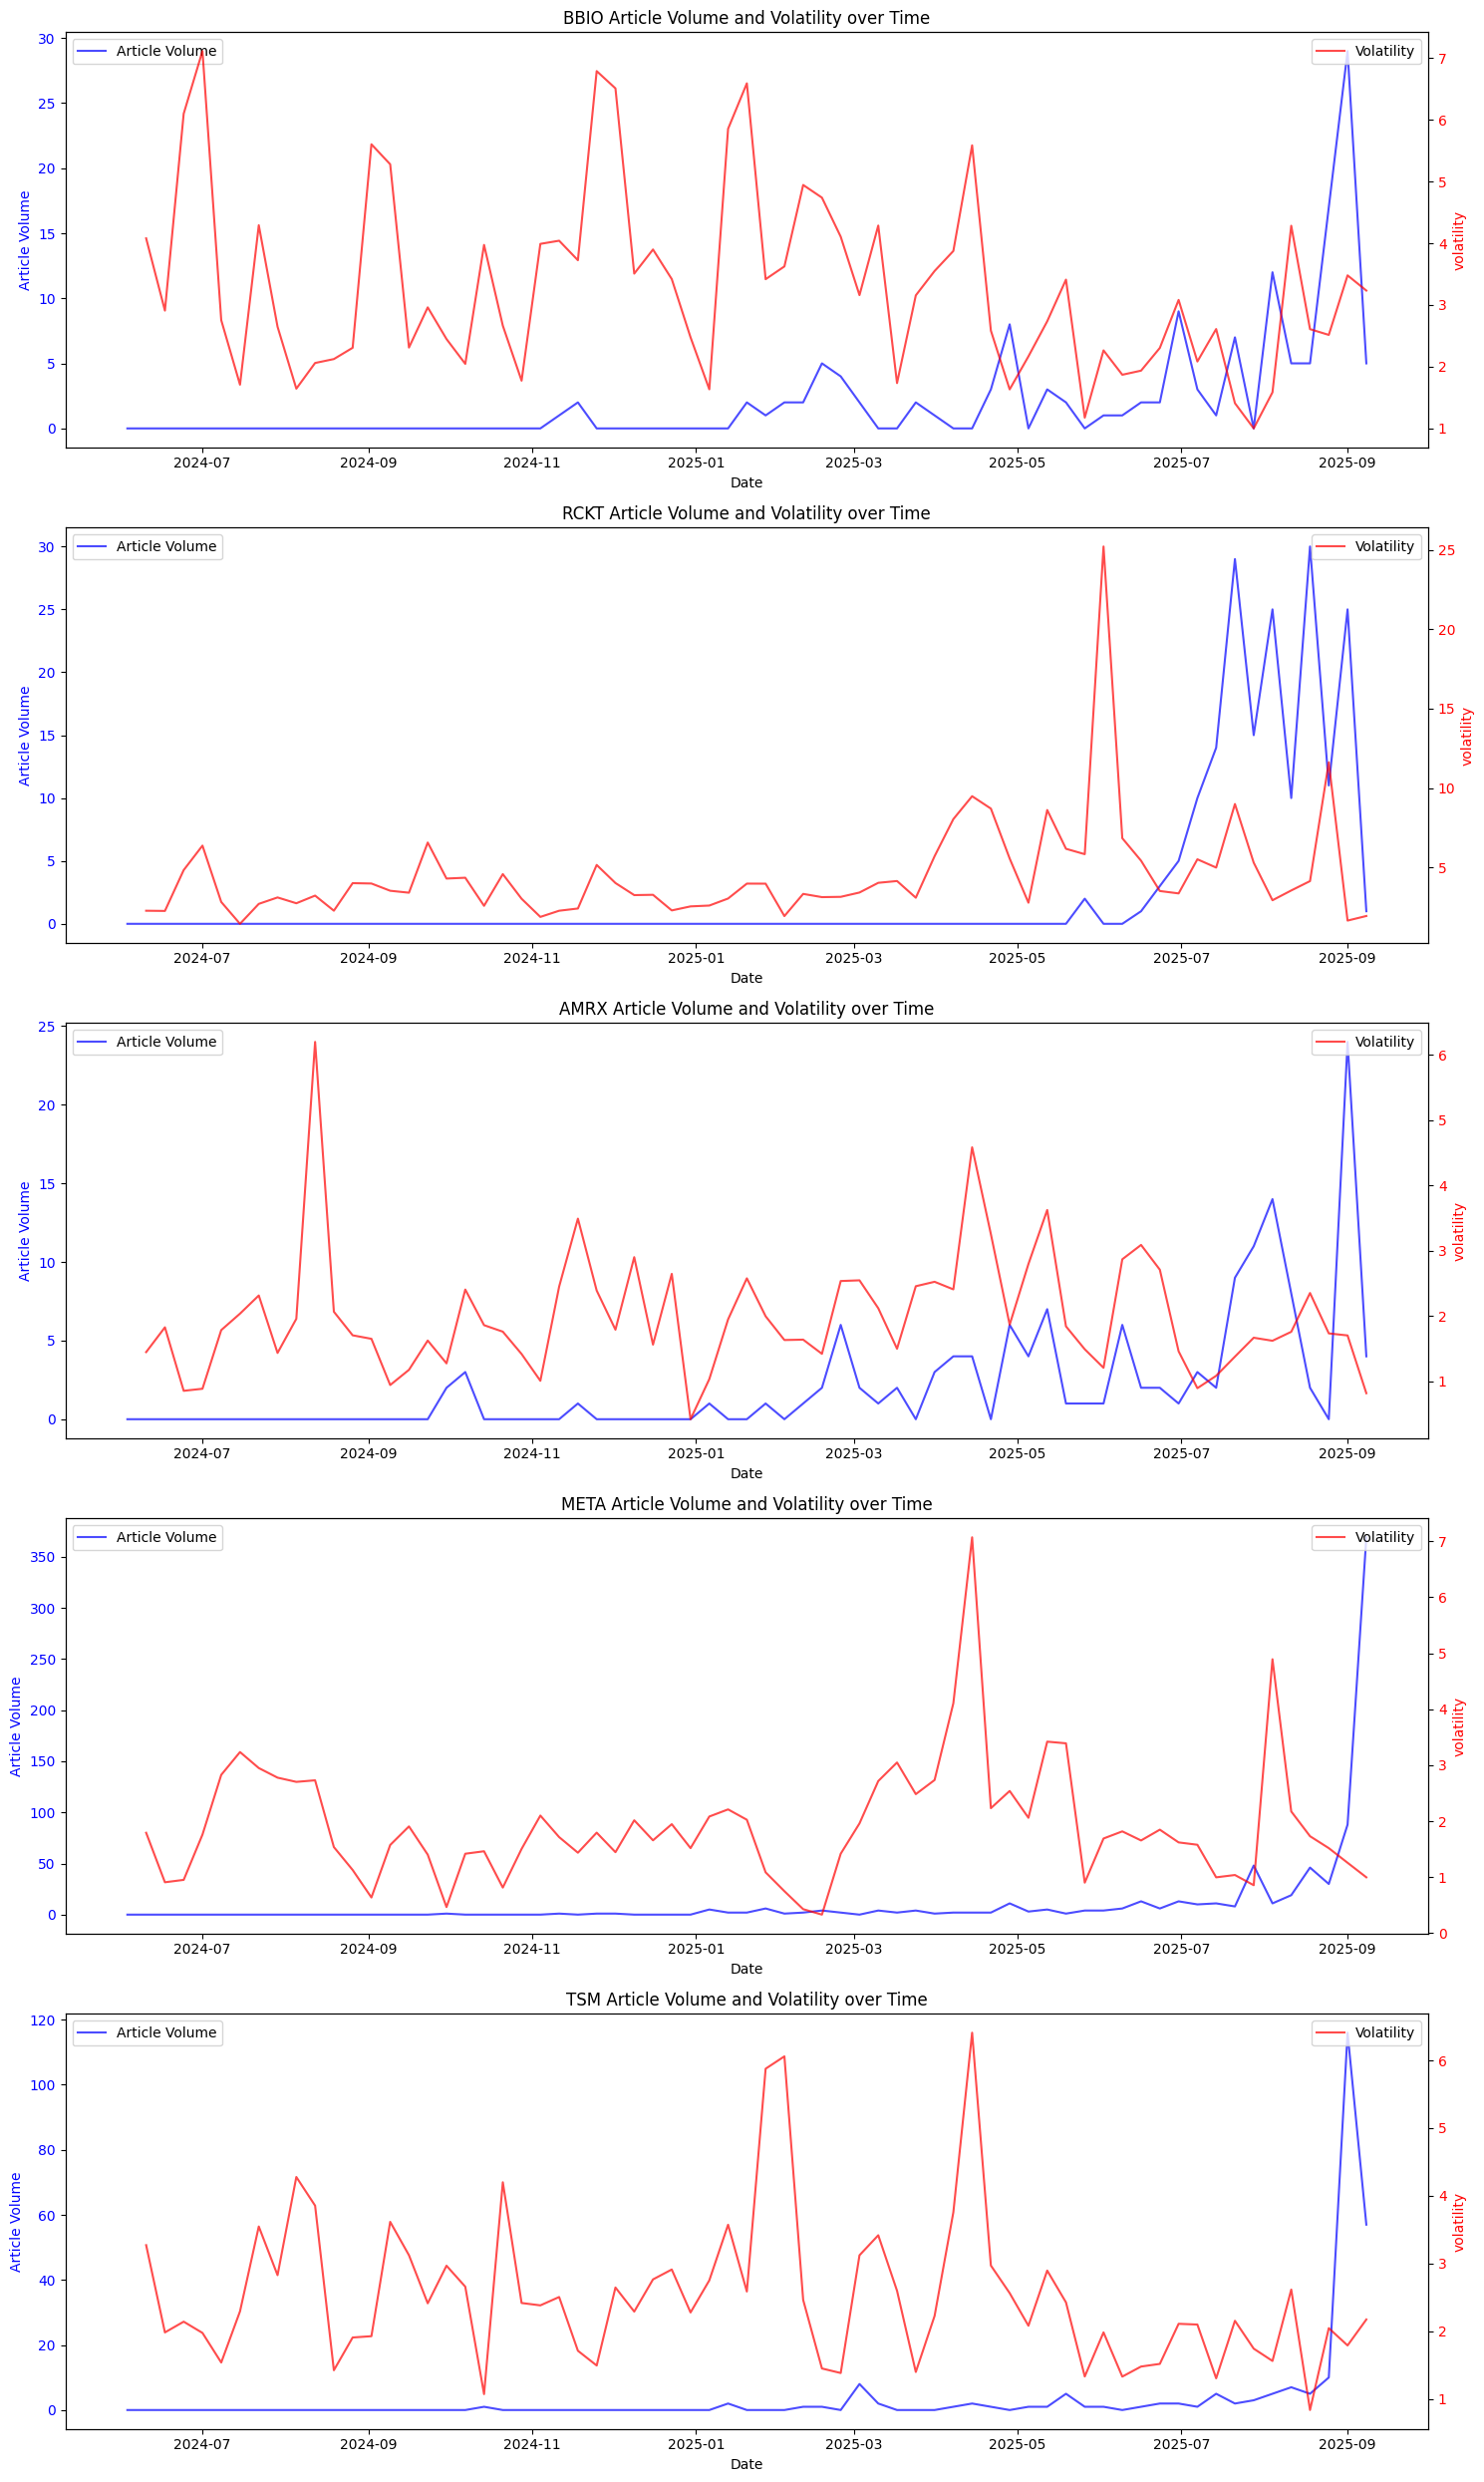

In [244]:
plot_volume_vs_volatility(df, tickers)

### Correlation Analysis

In [245]:
def get_corr_roc(df, tickers):
    for ticker in tickers:
        roc_col = f'{ticker} ROC'
        sentiment_col = f'{ticker} Sentiment'
        
        # Adjusted ROC (subtract SPY ROC)
        adjusted_roc = (df[roc_col] - df['SPY ROC'])
        
        # Calculate the correlation between adjusted ROC and sentiment
        correlation = adjusted_roc.corr(df[sentiment_col])
        
        # Print the result
        print(f'Correlation between {ticker} adjusted ROC and sentiment: {correlation}')
def get_corr_vol(df, tickers):
    for ticker in tickers:
        vol_col = f'{ticker} Volatility'
        sentiment_col = f'{ticker} Sentiment'

        correlation = df[vol_col].corr(df[sentiment_col])

        print(f'Correlation between {ticker} volatility and sentiment: {correlation}')

def get_corr_volume(df, tickers):
    for ticker in tickers:
        vol_col = f'{ticker} Volatility'
        volume_col = f'{ticker} Article Volume'

        correlation = df[vol_col].corr(df[volume_col])

        print(f'Correlation between {ticker} volatility and volume: {correlation}')

def get_corr_sentiment_volume(df, tickers):
    for ticker in tickers:
        sentiment_col = f'{ticker} Sentiment'
        volume_col = f'{ticker} Article Volume'

        correlation = df[volume_col].corr(df[sentiment_col])

        print(f'Correlation between {ticker} volume and sentiment: {correlation}')


In [246]:
get_corr_roc(df, tickers)
print('\n')
get_corr_vol(df, tickers)
print('\n')
get_corr_volume(df, tickers)
print('\n')
get_corr_sentiment_volume(df, tickers)

Correlation between BBIO adjusted ROC and sentiment: -0.025710650896350138
Correlation between RCKT adjusted ROC and sentiment: 0.04049826524774969
Correlation between AMRX adjusted ROC and sentiment: 0.0450883225028677
Correlation between META adjusted ROC and sentiment: 0.1691327232000681
Correlation between TSM adjusted ROC and sentiment: 0.04651476235982676


Correlation between BBIO volatility and sentiment: 0.026433888066133258
Correlation between RCKT volatility and sentiment: -0.00969313433486899
Correlation between AMRX volatility and sentiment: -0.04993774244670413
Correlation between META volatility and sentiment: -0.1567403438176099
Correlation between TSM volatility and sentiment: -0.03576165686724397


Correlation between BBIO volatility and volume: -0.10987203847487421
Correlation between RCKT volatility and volume: 0.06448699256879939
Correlation between AMRX volatility and volume: 0.019967877636888284
Correlation between META volatility and volume: -0.13533674858657602

### Code used to create the daily dataframe with sentiment and stock data for TSM (currently commented out)

In [247]:
# DATA GENERATION CELL - COMMENTED OUT (using existing TSM_data.csv)
# import yfinance as yf
# import numpy as np
# import pandas as pd
# 
# # Define start and end dates
# start_date = '2024-06-01'
# end_date = pd.Timestamp.today()
# 
# # Fetch historical data for TSM
# data = yf.download('TSM', start=start_date, end=end_date)
# 
# # Ensure the data has the 'Adj Close' column for adjusted close prices
# if 'Close' not in data.columns:
#     raise ValueError("Adjusted Close prices not found in the data.")
# 
# # Calculate daily log returns
# data['Log Return'] = np.log(data['Close'] / data['Close'].shift(1))
# 
# # Check if 'Log Return' is created successfully
# print(data[['Close', 'Log Return']].head(10))
# 
# # Calculate rolling volatility (use a window size > 1 for standard deviation)
# window_size = 3 if len(data) < 5 else 5
# data['Volatility'] = data['Log Return'].rolling(window=window_size).std()
# 
# # Verify that the 'Volatility' column has been created successfully
# print(data[['Log Return', 'Volatility']].head(10))
# 
# # Drop NaN values resulting from the rolling window and log return calculation
# if 'Volatility' in data.columns:
#     data = data[5:]
# else:
#     raise KeyError("Volatility column was not created successfully.")
# 
# # Reset the index for a clean DataFrame
# volatility_df = data[['Volatility']]

In [248]:
# DATA GENERATION CELL - COMMENTED OUT (using existing TSM_data.csv)
# from datetime import timedelta
# volatility_df = volatility_df.reset_index()
# volatility_df.columns = ['Date', 'Volatility']
# 
# # Define a function to fetch sentiment and volume for each date
# def fetch_sentiment_and_volume(date, query="Taiwan Semiconductor Manufacturing Company"):
#     """
#     Fetch the average sentiment and volume of articles for a specific date.
#     
#     Parameters:
#         date (datetime): The date for which to fetch data.
#         query (str): The search query for Google News articles.
#     
#     Returns:
#         tuple: Average sentiment and volume of articles for the given date.
#     """
#     # Convert date to strings for start and end of the day
#     start_date = date.strftime('%Y-%m-%d')
#     end_date = (date + timedelta(days=1)).strftime('%Y-%m-%d')
#     
#     # Get sentiment scores and count using your `get_sentiment` function
#     sentiment = get_sentiment(query, start_date, end_date)
#     news_feed = feedparser.parse(
#         f"https://news.google.com/rss/search?q={query.replace(' ', '%20')}+after:{start_date}+before:{end_date}&hl=en-US&gl=US&ceid=US:en"
#     )
#     volume = len(news_feed.entries)  # Count the number of articles
#     print(date)
#     
#     return sentiment, volume
# 
# # Initialize empty lists to store sentiment and volume
# sentiment_list = []
# volume_list = []
# 
# # Loop through each date in the DataFrame and fetch sentiment and volume
# for date in volatility_df['Date']:
#     avg_sentiment, article_volume = fetch_sentiment_and_volume(pd.Timestamp(date))
#     sentiment_list.append(avg_sentiment)
#     volume_list.append(article_volume)
# 
# # Add the sentiment and volume as new columns to the DataFrame
# volatility_df['Average Sentiment'] = sentiment_list
# volatility_df['Volume'] = volume_list
# 
# # Display the resulting DataFrame
# print(volatility_df.head())

In [249]:
# DATA GENERATION CELL - COMMENTED OUT (TSM_data.csv already exists)
# volatility_df.to_csv('TSM_data.csv')

In [250]:
data = pd.read_csv('data/TSM_data.csv')

### LSTM

Preprocess the data for LSTM training by making X sequential and MinMaxScaling the volatilities

In [251]:
# Extract the volatility values
volatility_values = np.array(data['Volatility'])
volatility_values = volatility_values.reshape(-1, 1)  # Reshape to 2D array for scaling

# Scale the data to the range [0, 1] using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(volatility_values)

In [252]:
# Create sequences for LSTM: Using a sequence length (e.g., 30 days) to predict the next day's volatility
sequence_length = 10

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # Use the past 'sequence_length' days as input
        y.append(data[i, 0])  # The next day's volatility is the target
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length)

# Reshape X to be suitable for LSTM input: [samples, timesteps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training (80%) and temporary (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)

# Now, split the temporary set into validation (50%) and test (50%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Now you have X_train, X_val, X_test, y_train, y_val, y_test

### LSTMGridSearchClass:
Create and use a grid search class to scan for the best parameters for the LSTM

In [253]:
from sklearn.model_selection import ParameterGrid
import numpy as np


class GridSearchLSTMModel(nn.Module):
    """
    PyTorch LSTM model for grid search.
    
    Architecture:
        - LSTM layer: configurable units
        - Dense layer 1: configurable units with ReLU
        - Dense layer 2: configurable units with ReLU
        - Output layer: 1 unit
    """
    def __init__(self, input_shape, lstm_units, dense_units):
        super(GridSearchLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_shape[1],
            hidden_size=lstm_units,
            batch_first=True
        )
        self.fc1 = nn.Linear(lstm_units, dense_units)
        self.fc2 = nn.Linear(dense_units, dense_units)
        self.fc3 = nn.Linear(dense_units, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take output from last time step
        out = lstm_out[:, -1, :]
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


class LSTMGridSearch:
    """
    A class to perform grid search over hyperparameters for an LSTM model.

    Attributes:
        param_grid (list): A list of hyperparameter combinations to search over.
        input_shape (tuple): The shape of the input data (timesteps, features).
        results (list): A list to store validation losses and corresponding hyperparameters.
        best_params (dict): The best hyperparameters from the grid search.
        best_model (nn.Module): The LSTM model trained with the best parameters.
    """
    def __init__(self, param_grid, input_shape):
        """
        Initialize the grid search with the given parameter grid and input shape.

        Args:
            param_grid (dict): A dictionary of hyperparameter options.
            input_shape (tuple): The shape of the input data for the LSTM layer.
        """
        self.param_grid = list(ParameterGrid(param_grid))  # Create all parameter combinations
        self.input_shape = input_shape  # Shape of the input data
        self.results = []  # List to store results
        self.best_params = None  # To hold the best parameters
        self.best_model = None  # To hold the best model

    def create_model(self, lstm_units, dense_units, learning_rate):
        """
        Create a PyTorch LSTM model with the given parameters.

        Args:
            lstm_units (int): Number of units in the LSTM layer.
            dense_units (int): Number of units in the Dense layers.
            learning_rate (float): Learning rate for the Adam optimizer.

        Returns:
            tuple: (model, criterion, optimizer)
        """
        model = GridSearchLSTMModel(self.input_shape, lstm_units, dense_units)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        return model, criterion, optimizer

    def train_model(self, model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs, batch_size):
        """
        Train the model and return validation loss.

        Args:
            model: PyTorch model
            criterion: Loss function
            optimizer: Optimizer
            X_train: Training features
            y_train: Training targets
            X_val: Validation features
            y_val: Validation targets
            epochs: Number of epochs
            batch_size: Batch size

        Returns:
            tuple: (val_loss, trained_model)
        """
        # Convert to tensors
        X_train_t = torch.FloatTensor(X_train)
        y_train_t = torch.FloatTensor(y_train.reshape(-1, 1))
        X_val_t = torch.FloatTensor(X_val)
        y_val_t = torch.FloatTensor(y_val.reshape(-1, 1))
        
        n_samples = X_train_t.shape[0]
        
        for epoch in range(epochs):
            model.train()
            indices = torch.randperm(n_samples)
            
            for i in range(0, n_samples, batch_size):
                batch_indices = indices[i:min(i + batch_size, n_samples)]
                X_batch = X_train_t[batch_indices]
                y_batch = y_train_t[batch_indices]
                
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Print progress
            if (epoch + 1) % 5 == 0:
                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_val_t)
                    val_loss = criterion(val_outputs, y_val_t).item()
                print(f"  Epoch {epoch + 1}/{epochs}, Val Loss: {val_loss:.6f}")
        
        # Final validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t).item()
        
        return val_loss, model

    def fit(self, X_train, y_train, X_val, y_val):
        """
        Perform grid search by training models with each hyperparameter combination.

        Args:
            X_train (np.array): Training feature data.
            y_train (np.array): Training target data.
            X_val (np.array): Validation feature data.
            y_val (np.array): Validation target data.
        """
        for params in self.param_grid:
            print(f"Training with params: {params}")
            
            # Extract hyperparameters
            lstm_units = params['lstm_units']
            dense_units = params['dense_units']
            batch_size = params['batch_size']
            learning_rate = params['learning_rate']
            epochs = params['epochs']

            # Create model
            model, criterion, optimizer = self.create_model(lstm_units, dense_units, learning_rate)
            
            # Train and get validation loss
            val_loss, trained_model = self.train_model(
                model, criterion, optimizer,
                X_train, y_train, X_val, y_val,
                epochs, batch_size
            )

            self.results.append({'params': params, 'val_loss': val_loss})  # Save result

        # Find the best parameters based on minimum validation loss
        self.best_params = min(self.results, key=lambda x: x['val_loss'])['params']
        print(f"Best Parameters: {self.best_params}")

    def get_best_params(self):
        """
        Get the best parameters identified during the grid search.

        Returns:
            dict: Best hyperparameter combination.
        """
        return self.best_params

    def summary(self):
        """
        Print a summary of all hyperparameter combinations and their validation losses.
        """
        for result in self.results:
            print(f"Params: {result['params']}, Validation Loss: {result['val_loss']}")

    def create_best_model(self):
        """
        Create a model using the best hyperparameters.

        Returns:
            nn.Module: PyTorch model with the best hyperparameters.
        """
        if not self.best_params:
            raise ValueError("Grid search has not been performed yet. Call fit() first.")
        lstm_units = self.best_params['lstm_units']
        dense_units = self.best_params['dense_units']
        learning_rate = self.best_params['learning_rate']
        model, _, _ = self.create_model(lstm_units, dense_units, learning_rate)
        self.best_model = model
        return self.best_model


# Define the parameter grid for grid search
param_grid = {
    'lstm_units': [64, 128],  # LSTM units to try
    'dense_units': [32, 64],  # Dense layer units to try
    'batch_size': [16, 32],  # Batch sizes to try
    'learning_rate': [0.001, 0.0001],  # Learning rates to try
    'epochs': [10, 20],  # Number of epochs to try
}

# Define the input shape based on training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Initialize grid search
grid_search = LSTMGridSearch(param_grid, input_shape)

# Perform grid search
grid_search.fit(X_train, y_train, X_val, y_val)

# Retrieve the best parameters
best_params = grid_search.get_best_params()
print(f"Best Parameters: {best_params}")

# Create and train the best model with full training set
best_lstm_model = grid_search.create_best_model()

# Train the best model
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train.reshape(-1, 1))
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val.reshape(-1, 1))

criterion = nn.MSELoss()
optimizer = optim.Adam(best_lstm_model.parameters(), lr=best_params['learning_rate'])

n_samples = X_train_t.shape[0]
batch_size = best_params['batch_size']
epochs = best_params['epochs']

for epoch in range(epochs):
    best_lstm_model.train()
    indices = torch.randperm(n_samples)
    
    for i in range(0, n_samples, batch_size):
        batch_indices = indices[i:min(i + batch_size, n_samples)]
        X_batch = X_train_t[batch_indices]
        y_batch = y_train_t[batch_indices]
        
        outputs = best_lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation loss
    best_lstm_model.eval()
    with torch.no_grad():
        val_outputs = best_lstm_model(X_val_t)
        val_loss = criterion(val_outputs, y_val_t).item()
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {val_loss:.6f}")


Training with params: {'batch_size': 16, 'dense_units': 32, 'epochs': 10, 'learning_rate': 0.001, 'lstm_units': 64}
  Epoch 5/10, Val Loss: 0.010980
  Epoch 10/10, Val Loss: 0.006771
Training with params: {'batch_size': 16, 'dense_units': 32, 'epochs': 10, 'learning_rate': 0.001, 'lstm_units': 128}
  Epoch 5/10, Val Loss: 0.014256
  Epoch 10/10, Val Loss: 0.016454
Training with params: {'batch_size': 16, 'dense_units': 32, 'epochs': 10, 'learning_rate': 0.0001, 'lstm_units': 64}
  Epoch 5/10, Val Loss: 0.003426
  Epoch 10/10, Val Loss: 0.008927
Training with params: {'batch_size': 16, 'dense_units': 32, 'epochs': 10, 'learning_rate': 0.0001, 'lstm_units': 128}
  Epoch 5/10, Val Loss: 0.094144
  Epoch 10/10, Val Loss: 0.006699
Training with params: {'batch_size': 16, 'dense_units': 32, 'epochs': 20, 'learning_rate': 0.001, 'lstm_units': 64}
  Epoch 5/20, Val Loss: 0.014739
  Epoch 10/20, Val Loss: 0.013813
  Epoch 15/20, Val Loss: 0.004328
  Epoch 20/20, Val Loss: 0.008777
Training with

Evaluate the final model and add the predictions to the dataframe, data

In [254]:
# Evaluate the model on the test set
best_lstm_model.eval()
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test.reshape(-1, 1))

with torch.no_grad():
    test_outputs = best_lstm_model(X_test_t)
    test_loss = nn.MSELoss()(test_outputs, y_test_t).item()
print("Test Loss:", test_loss)

# Make predictions using the trained model
X_tensor = torch.FloatTensor(X)
with torch.no_grad():
    predictions = best_lstm_model(X_tensor).cpu().numpy()

# Inverse transform the scaled predictions to get the original volatility values
lstm_predictions = scaler.inverse_transform(predictions)


Test Loss: 0.00482882559299469


In [255]:
# Ensure 'Date' is a datetime object if it's not already
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column for LSTM predictions and initialize it with NaN
data['LSTM_Predictions'] = np.nan

# Start filling LSTM predictions from index 10 onward
start_index = 10

# Ensure that the length of lstm_predictions matches the number of rows starting from index 10
data.loc[start_index:, 'LSTM_Predictions'] = lstm_predictions.flatten()

Graph how well the LSTM predicted volatility and the training, validation, and test sets

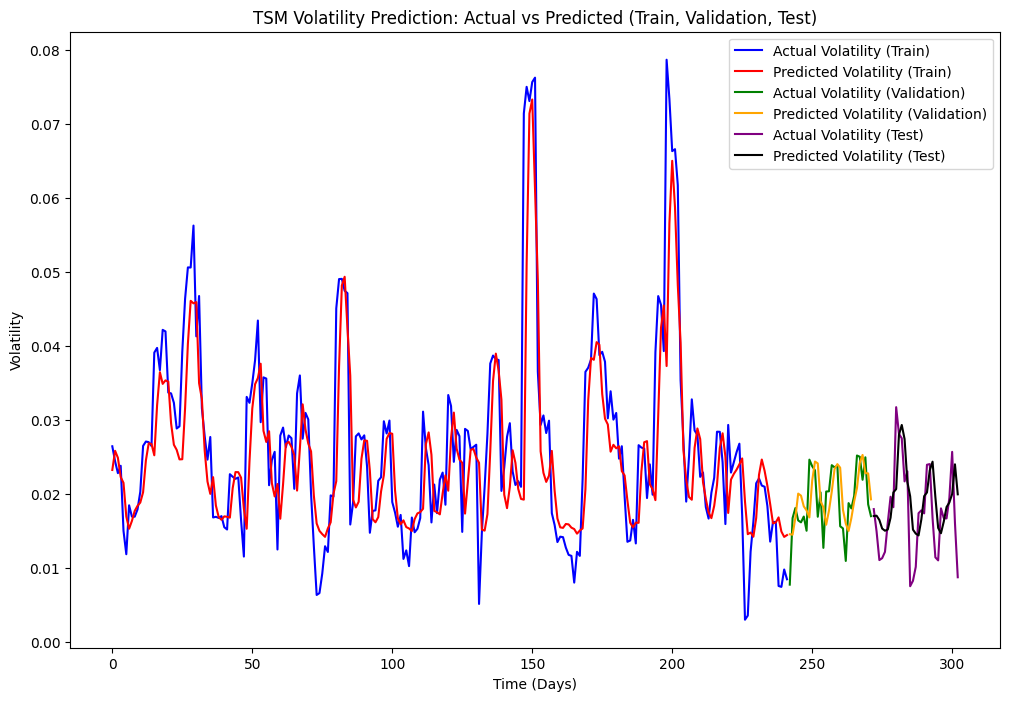

In [256]:
# Make predictions using the trained model on the train, validation, and test data
best_lstm_model.eval()

X_train_t = torch.FloatTensor(X_train)
X_val_t = torch.FloatTensor(X_val)
X_test_t = torch.FloatTensor(X_test)

with torch.no_grad():
    train_predictions = best_lstm_model(X_train_t).cpu().numpy()
    val_predictions = best_lstm_model(X_val_t).cpu().numpy()
    test_predictions = best_lstm_model(X_test_t).cpu().numpy()

# Inverse transform the predictions and actual values for train, validation, and test data
train_predictions = scaler.inverse_transform(train_predictions)
val_predictions = scaler.inverse_transform(val_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a combined plot for train, validation, and test data
plt.figure(figsize=(12, 8))

# Plot the training data
plt.plot(np.arange(len(y_train_actual)), y_train_actual, label='Actual Volatility (Train)', color='blue')
plt.plot(np.arange(len(train_predictions)), train_predictions, label='Predicted Volatility (Train)', color='red')

# Plot the validation data (after the training data)
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_val_actual)),
         y_val_actual, label='Actual Volatility (Validation)', color='green')
plt.plot(np.arange(len(train_predictions), len(train_predictions) + len(val_predictions)),
         val_predictions, label='Predicted Volatility (Validation)', color='orange')

# Plot the test data (after the validation data)
plt.plot(np.arange(len(y_train_actual) + len(y_val_actual), len(y_train_actual) + len(y_val_actual) + len(y_test_actual)),
         y_test_actual, label='Actual Volatility (Test)', color='purple')
plt.plot(np.arange(len(train_predictions) + len(val_predictions), len(train_predictions) + len(val_predictions) + len(test_predictions)),
         test_predictions, label='Predicted Volatility (Test)', color='black')

# Add labels and title
plt.title('TSM Volatility Prediction: Actual vs Predicted (Train, Validation, Test)')
plt.xlabel('Time (Days)')
plt.ylabel('Volatility')

# Add a legend
plt.legend()

# Show the plot
plt.show()


Do the same thing except we make predictions based off of the models own previous predictions over the test set to see how well the model is able to simulate change in volatility over time

In [257]:
# Initialize an empty list to store the predictions
predictions = []

# Use the first input from X_test to start the prediction
current_input = X_test[0]  # Initial input is the first window from the test set

# Set model to evaluation mode
best_lstm_model.eval()

# Loop through all time steps in X_test
for i in range(len(X_test)):
    # Convert to tensor and predict
    input_tensor = torch.FloatTensor(np.reshape(current_input, (1, current_input.shape[0], current_input.shape[1])))
    with torch.no_grad():
        predicted_value = best_lstm_model(input_tensor).cpu().numpy()

    # Store the prediction
    predictions.append(predicted_value[0, 0])

    # Update the current input by using the predicted value for the next time step
    if i < len(X_test) - 1:
        # Shift the window and include the prediction as the next input
        current_input = np.roll(current_input, -1, axis=0)  # Remove the first element
        current_input[-1] = predicted_value  # Add the new prediction as the last element

# Convert the predictions list into a numpy array
predictions = np.array(predictions)

# Inverse transform the predictions using the same scaler used during training
predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1))
# Now you can compare predictions to actual values (y_test) and visualize them


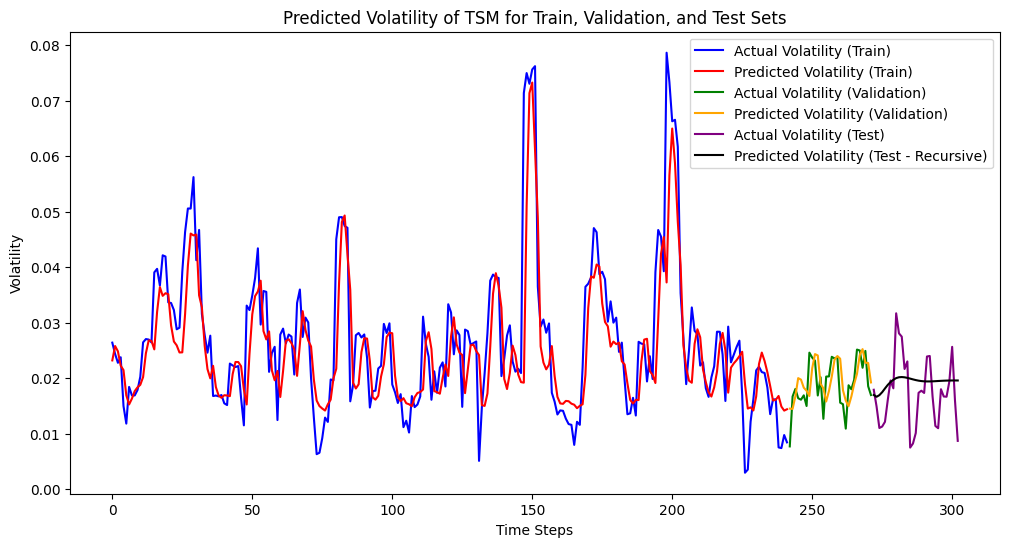

In [258]:
# Assuming you have the following variables:
# train_predictions: predictions on the training set
# val_predictions: predictions on the validation set
# test_predictions: predictions on the test set (using recursive predictions)

# Concatenate all predictions (train, validation, and test) for plotting
all_predictions = np.concatenate([train_predictions, val_predictions, test_predictions])

# Create the full time index for plotting, considering the combined length of train, val, and test data
full_time_index = np.arange(len(train_predictions) + len(val_predictions) + len(test_predictions))

# Plot actual vs predicted values for the entire dataset
plt.plot(np.arange(len(y_train_actual)), y_train_actual, label='Actual Volatility (Train)', color='blue')
plt.plot(np.arange(len(train_predictions)), train_predictions, label='Predicted Volatility (Train)', color='red')
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_val_actual)),
         y_val_actual, label='Actual Volatility (Validation)', color='green')
plt.plot(np.arange(len(train_predictions), len(train_predictions) + len(val_predictions)), val_predictions, label='Predicted Volatility (Validation)', color='orange')
plt.plot(np.arange(len(y_train_actual) + len(y_val_actual), len(y_train_actual) + len(y_val_actual) + len(y_test_actual)),
         y_test_actual, label='Actual Volatility (Test)', color='purple')
plt.plot(np.arange(len(train_predictions) + len(val_predictions), len(train_predictions) + len(val_predictions) + len(test_predictions)),
         predictions_inverse, label='Predicted Volatility (Test - Recursive)', color='black')

# Optionally, plot the actual values if needed (e.g., y_train, y_val, y_test)
# plt.plot(full_time_index, actual_values, label='Actual Volatility', color='green')

# Add labels and legend
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend()
plt.title('Predicted Volatility of TSM for Train, Validation, and Test Sets')
plt.show()

### Linear Regression

Create new features using our existing features: 'Average Sentiment' and 'Article Volume'

In [259]:
# Assuming 'data' is your dataframe
data['Average Sentiment^2'] = data['Average Sentiment'] ** 2
data['Volume^2'] = data['Volume'] ** 2
data['Average Sentiment * Volume'] = data['Average Sentiment'] * data['Volume']

Use grid search over the regularization strength to find the optimal parameter for the model

In [260]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Assuming 'data' is your dataframe
# Define the features and target
features = ['Average Sentiment^2', 'Volume^2', 'Average Sentiment * Volume', 'Volume', 'Average Sentiment']
target = 'Volatility'

# Prepare the feature matrix (X) and target vector (y)
X = data[features]
y = data[target]

# Split the data into training, validation, and testing sets (60% train, 20% validation, 20% test)
# shuffle=False to prevent time series data leakage
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Set up the Ridge regression model (regularized linear regression)
ridge = Ridge()

# Define the hyperparameters grid to search over (for regularization)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Regularization strength
}

# Set up GridSearchCV to search for the best alpha value
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV on the training set
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters from GridSearchCV:", grid_search.best_params_)

# Get the best model from the grid search
best_linreg_model = grid_search.best_estimator_

# Evaluate the model on the validation set
y_val_pred = best_linreg_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = val_mse ** 0.5

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation Root Mean Squared Error: {val_rmse}')

# Evaluate the model on the test set
y_test_pred = best_linreg_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')

Best hyperparameters from GridSearchCV: {'alpha': 0.01}
Validation Mean Squared Error: 0.0002500803409923266
Validation Root Mean Squared Error: 0.01581392870201224
Test Mean Squared Error: 0.0002570018768359572
Test Root Mean Squared Error: 0.01603127807867973


Add the predictions of the linear regression model to the dataframe

In [261]:
linreg_predictions = best_linreg_model.predict(X)

data['linreg predictions'] = linreg_predictions

Plot the predicted volatilities against the actual volatilities

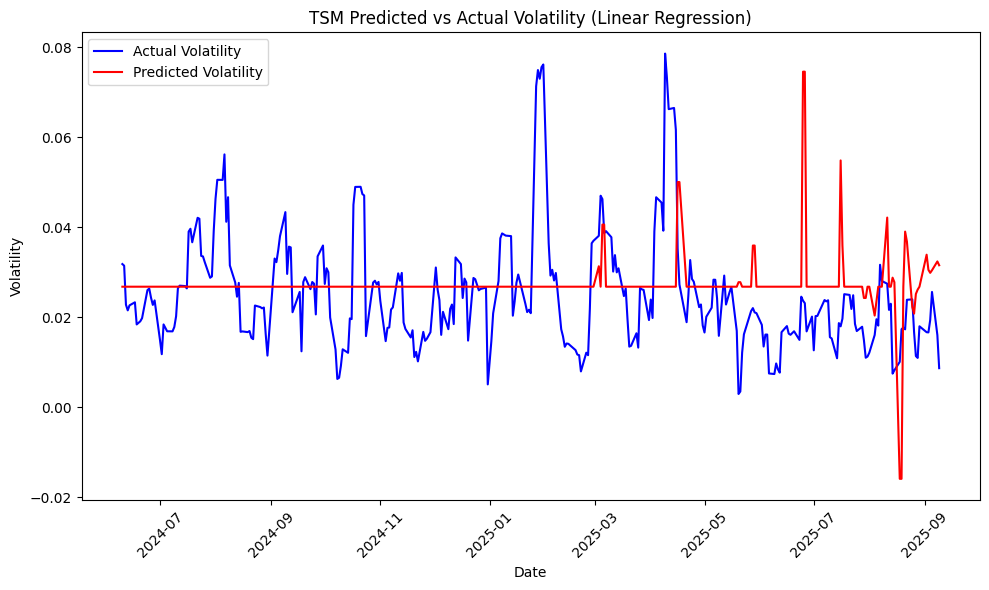

In [262]:
import matplotlib.pyplot as plt

# Make predictions on the test set using the best model
y_pred = best_linreg_model.predict(X)

# Assuming 'data' has a 'Date' column
# Use the 'Date' column for plotting, make sure it's in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Get the corresponding dates for the test set
dates = data.loc[X.index, 'Date']

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(dates, y, label='Actual Volatility', color='blue')
plt.plot(dates, y_pred, label='Predicted Volatility', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('TSM Predicted vs Actual Volatility (Linear Regression)')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### Neural Network

Train neural networks using grid search again to find the best hyperparameters and used standard scalar for preprocessing

In [263]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


class FeedforwardNN(nn.Module):
    """
    PyTorch feedforward neural network for regression.
    
    Architecture:
        - Hidden layer 1: configurable units with ReLU
        - Hidden layer 2: configurable units with ReLU
        - Output layer: 1 unit
    """
    def __init__(self, input_dim, units_1, units_2):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, units_1)
        self.fc2 = nn.Linear(units_1, units_2)
        self.fc3 = nn.Linear(units_2, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Assuming 'data' is your dataframe with the necessary columns
# Define the features and target
features = ['Average Sentiment', 'Volume']  # Only volume and sentiment as features
target = 'Volatility'

# Prepare the feature matrix (X) and target vector (y)
X = data[features]
y = data[target]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training, validation, and testing sets (80% train, 10% validation, 10% test)
# shuffle=False to prevent time series data leakage
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Define the parameter grid for the grid search
param_grid = {
    'units_1': [32, 64, 128],  # Number of neurons in the first layer
    'units_2': [16, 32, 64],   # Number of neurons in the second layer
    'learning_rate': [1e-4, 1e-3, 1e-2]  # Learning rates to try
}

# Initialize variables to track the best model
best_nn_model = None
best_val_loss = float('inf')
best_params = {}

# Convert to tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train.values.reshape(-1, 1))
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val.values.reshape(-1, 1))
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test.values.reshape(-1, 1))

# Perform the grid search
for units_1 in param_grid['units_1']:
    for units_2 in param_grid['units_2']:
        for learning_rate in param_grid['learning_rate']:
            # Define the model
            model = FeedforwardNN(input_dim=X_train.shape[1], units_1=units_1, units_2=units_2)
            
            # Loss and optimizer
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            
            # Train the model
            model.train()
            n_samples = X_train_t.shape[0]
            batch_size = 32
            epochs = 10
            
            for epoch in range(epochs):
                indices = torch.randperm(n_samples)
                for i in range(0, n_samples, batch_size):
                    batch_indices = indices[i:min(i + batch_size, n_samples)]
                    X_batch = X_train_t[batch_indices]
                    y_batch = y_train_t[batch_indices]
                    
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            # Evaluate the model on the validation set
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_t)
                val_loss = criterion(val_outputs, y_val_t).item()
            
            # Track the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_nn_model = model
                best_params = {'units_1': units_1, 'units_2': units_2, 'learning_rate': learning_rate}

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_val_loss)

# Evaluate the best model on the test set
best_nn_model.eval()
with torch.no_grad():
    test_outputs = best_nn_model(X_test_t)
    test_loss = nn.MSELoss()(test_outputs, y_test_t).item()
print(f'Test Loss: {test_loss}')


Best Hyperparameters: {'units_1': 64, 'units_2': 16, 'learning_rate': 0.01}
Best Validation Loss: 9.307605068897828e-05
Test Loss: 0.00014464696869254112


In [264]:
# Make predictions using the trained NN model
best_nn_model.eval()
X_scaled_t = torch.FloatTensor(X_scaled)
with torch.no_grad():
    nn_pred = best_nn_model(X_scaled_t).cpu().numpy()

data['nn predictions'] = nn_pred


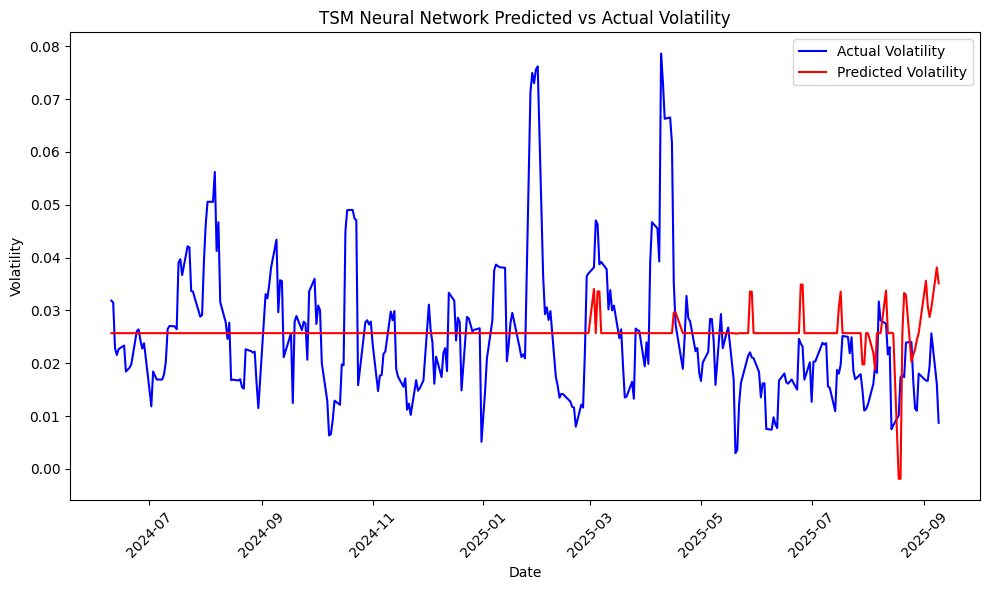

In [265]:
import matplotlib.pyplot as plt

# Make predictions on the test set using the best model
best_nn_model.eval()
X_scaled_t = torch.FloatTensor(X_scaled)
with torch.no_grad():
    y_pred = best_nn_model(X_scaled_t).cpu().numpy()

# Assuming 'data' has a 'Date' column
# Use the 'Date' column for plotting, make sure it's in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Get the corresponding dates for the test set
dates = data.loc[X.index, 'Date']

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(dates, y, label='Actual Volatility', color='blue')
plt.plot(dates, y_pred, label='Predicted Volatility', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('TSM Neural Network Predicted vs Actual Volatility')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


### Mixed Model
Preprocess the data, taking in the predictions from the three previous models as features

In [266]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

mixed_modeling_data = data[10:]
X = mixed_modeling_data[['nn predictions', 'LSTM_Predictions', 'linreg predictions']]

# Target (dependent variable)
y = mixed_modeling_data['Volatility']

# Split the data into training and testing sets
# shuffle=False to prevent time series data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize the linear regression model
mixed_model = LinearRegression()

# Fit the model on the training data
mixed_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mixed_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print(f'Test MSE: {mse}')

Test MSE: 3.4147255188608326e-05


In [267]:
mixed_preds = mixed_model.predict(X)

In [268]:
mixed_modeling_data['mixed predictions'] = mixed_preds

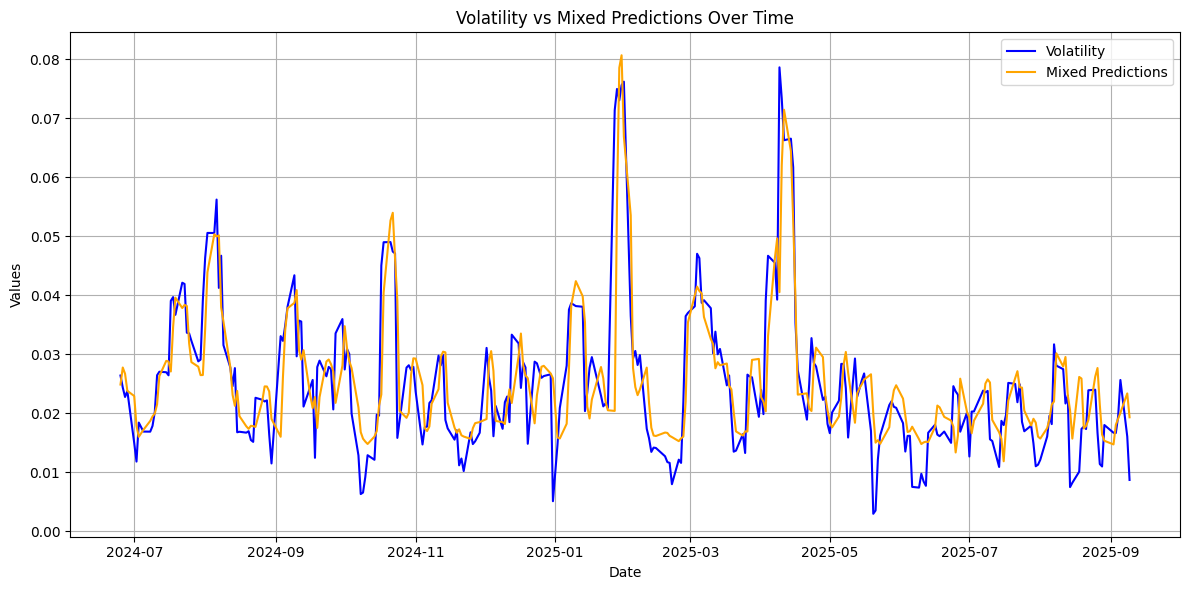

In [269]:
import matplotlib.pyplot as plt

# Ensure 'Date' is in datetime format
mixed_modeling_data['Date'] = pd.to_datetime(mixed_modeling_data['Date'])

# Sort the data by date for proper plotting
mixed_modeling_data = mixed_modeling_data.sort_values('Date')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(mixed_modeling_data['Date'], mixed_modeling_data['Volatility'], label='Volatility', color='blue')
plt.plot(mixed_modeling_data['Date'], mixed_modeling_data['mixed predictions'], label='Mixed Predictions', color='orange')

# Customize the plot
plt.title('Volatility vs Mixed Predictions Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

## Baseline vs Sentiment-Augmented Model Comparison

Compare models trained with and without sentiment features to quantify the impact of sentiment on IV prediction accuracy.

In [270]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# ============================================================
# BASELINE MODEL COMPARISON: With vs Without Sentiment Features
# ============================================================

print("=" * 70)
print("BASELINE VS SENTIMENT-AUGMENTED MODEL COMPARISON")
print("=" * 70)

# Reload data to ensure clean state
data = pd.read_csv('data/TSM_data.csv')

# Create polynomial features for sentiment
data['Average Sentiment^2'] = data['Average Sentiment'] ** 2
data['Volume^2'] = data['Volume'] ** 2
data['Average Sentiment * Volume'] = data['Average Sentiment'] * data['Volume']

results = []

# ============================================================
# 1. LINEAR REGRESSION COMPARISON
# ============================================================
print("\n" + "-" * 50)
print("LINEAR REGRESSION")
print("-" * 50)

# Features WITH sentiment
features_with_sentiment = ['Average Sentiment^2', 'Volume^2', 'Average Sentiment * Volume', 'Volume', 'Average Sentiment']
# Features WITHOUT sentiment (baseline)
features_without_sentiment = ['Volume^2', 'Volume']  # Only volume-based features

target = 'Volatility'

# Prepare data
X_with_sent = data[features_with_sentiment]
X_without_sent = data[['Volume']].copy()  # Just volume as baseline
X_without_sent['Volume^2'] = data['Volume'] ** 2
y = data[target]

# Split data (same splits for fair comparison)
X_train_ws, X_temp_ws, y_train, y_temp = train_test_split(X_with_sent, y, test_size=0.4, random_state=42, shuffle=False)
X_val_ws, X_test_ws, y_val, y_test = train_test_split(X_temp_ws, y_temp, test_size=0.5, random_state=42, shuffle=False)

X_train_ns, X_temp_ns, _, _ = train_test_split(X_without_sent, y, test_size=0.4, random_state=42, shuffle=False)
X_val_ns, X_test_ns, _, _ = train_test_split(X_temp_ns, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Train WITH sentiment
ridge_ws = Ridge(alpha=1.0)
ridge_ws.fit(X_train_ws, y_train)
pred_ws = ridge_ws.predict(X_test_ws)
rmse_ws = np.sqrt(mean_squared_error(y_test, pred_ws))

# Train WITHOUT sentiment (baseline)
ridge_ns = Ridge(alpha=1.0)
ridge_ns.fit(X_train_ns, y_train)
pred_ns = ridge_ns.predict(X_test_ns)
rmse_ns = np.sqrt(mean_squared_error(y_test, pred_ns))

improvement_lr = ((rmse_ns - rmse_ws) / rmse_ns) * 100
results.append({
    'Model': 'Linear Regression',
    'RMSE (No Sentiment)': rmse_ns,
    'RMSE (With Sentiment)': rmse_ws,
    'Improvement (%)': improvement_lr
})

print(f"  RMSE without sentiment: {rmse_ns:.6f}")
print(f"  RMSE with sentiment:    {rmse_ws:.6f}")
print(f"  Improvement:            {improvement_lr:.2f}%")

# ============================================================
# 2. NEURAL NETWORK COMPARISON
# ============================================================
print("\n" + "-" * 50)
print("NEURAL NETWORK")
print("-" * 50)

# Features for NN
nn_features_with_sent = ['Average Sentiment', 'Volume']
nn_features_without_sent = ['Volume']

X_nn_ws = data[nn_features_with_sent]
X_nn_ns = data[nn_features_without_sent]

# Scale features
scaler_ws = StandardScaler()
scaler_ns = StandardScaler()

X_nn_ws_scaled = scaler_ws.fit_transform(X_nn_ws)
X_nn_ns_scaled = scaler_ns.fit_transform(X_nn_ns)

# Split
X_train_nn_ws, X_temp_nn_ws, y_train_nn, y_temp_nn = train_test_split(X_nn_ws_scaled, y, test_size=0.2, random_state=42, shuffle=False)
X_val_nn_ws, X_test_nn_ws, y_val_nn, y_test_nn = train_test_split(X_temp_nn_ws, y_temp_nn, test_size=0.5, random_state=42, shuffle=False)

X_train_nn_ns, X_temp_nn_ns, _, _ = train_test_split(X_nn_ns_scaled, y, test_size=0.2, random_state=42, shuffle=False)
X_val_nn_ns, X_test_nn_ns, _, _ = train_test_split(X_temp_nn_ns, y_temp_nn, test_size=0.5, random_state=42, shuffle=False)

# Define NN model class
class BaselineNN(nn.Module):
    def __init__(self, input_dim):
        super(BaselineNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def train_nn_model(X_train, y_train, X_test, y_test, input_dim, epochs=50):
    model = BaselineNN(input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train.values.reshape(-1, 1))
    X_test_t = torch.FloatTensor(X_test)
    y_test_t = torch.FloatTensor(y_test.values.reshape(-1, 1))
    
    model.train()
    for epoch in range(epochs):
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_t).numpy()
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse, model

# Train both versions
rmse_nn_ws, _ = train_nn_model(X_train_nn_ws, y_train_nn, X_test_nn_ws, y_test_nn, input_dim=2)
rmse_nn_ns, _ = train_nn_model(X_train_nn_ns, y_train_nn, X_test_nn_ns, y_test_nn, input_dim=1)

improvement_nn = ((rmse_nn_ns - rmse_nn_ws) / rmse_nn_ns) * 100
results.append({
    'Model': 'Neural Network',
    'RMSE (No Sentiment)': rmse_nn_ns,
    'RMSE (With Sentiment)': rmse_nn_ws,
    'Improvement (%)': improvement_nn
})

print(f"  RMSE without sentiment: {rmse_nn_ns:.6f}")
print(f"  RMSE with sentiment:    {rmse_nn_ws:.6f}")
print(f"  Improvement:            {improvement_nn:.2f}%")

# ============================================================
# 3. LSTM COMPARISON
# ============================================================
print("\n" + "-" * 50)
print("LSTM")
print("-" * 50)

# LSTM WITHOUT sentiment (volatility only - current baseline)
volatility_values = data['Volatility'].values.reshape(-1, 1)
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_vol = scaler_lstm.fit_transform(volatility_values)

sequence_length = 10

def create_sequences_1d(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_lstm_ns, y_lstm = create_sequences_1d(scaled_vol, sequence_length)
X_lstm_ns = X_lstm_ns.reshape(X_lstm_ns.shape[0], X_lstm_ns.shape[1], 1)

# LSTM WITH sentiment (multivariate)
# Combine volatility with sentiment features
lstm_features = data[['Volatility', 'Average Sentiment', 'Volume']].values
scaler_lstm_mv = MinMaxScaler(feature_range=(0, 1))
scaled_mv = scaler_lstm_mv.fit_transform(lstm_features)

def create_sequences_mv(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, :])  # All features
        y.append(data[i, 0])  # Predict volatility
    return np.array(X), np.array(y)

X_lstm_ws, y_lstm_ws = create_sequences_mv(scaled_mv, sequence_length)

# Split data
X_train_lstm_ns, X_temp_lstm_ns, y_train_lstm, y_temp_lstm = train_test_split(X_lstm_ns, y_lstm, test_size=0.2, shuffle=False)
X_val_lstm_ns, X_test_lstm_ns, y_val_lstm, y_test_lstm = train_test_split(X_temp_lstm_ns, y_temp_lstm, test_size=0.5, shuffle=False)

X_train_lstm_ws, X_temp_lstm_ws, _, _ = train_test_split(X_lstm_ws, y_lstm_ws, test_size=0.2, shuffle=False)
X_val_lstm_ws, X_test_lstm_ws, _, _ = train_test_split(X_temp_lstm_ws, y_temp_lstm, test_size=0.5, shuffle=False)

# Define LSTM model
class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=50):
        super(BaselineLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

def train_lstm_baseline(X_train, y_train, X_test, y_test, input_size, epochs=30):
    model = BaselineLSTM(input_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train.reshape(-1, 1))
    X_test_t = torch.FloatTensor(X_test)
    
    model.train()
    for epoch in range(epochs):
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_t).numpy()
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

# Train both LSTM versions
rmse_lstm_ns = train_lstm_baseline(X_train_lstm_ns, y_train_lstm, X_test_lstm_ns, y_test_lstm, input_size=1)
rmse_lstm_ws = train_lstm_baseline(X_train_lstm_ws, y_train_lstm, X_test_lstm_ws, y_test_lstm, input_size=3)

improvement_lstm = ((rmse_lstm_ns - rmse_lstm_ws) / rmse_lstm_ns) * 100
results.append({
    'Model': 'LSTM',
    'RMSE (No Sentiment)': rmse_lstm_ns,
    'RMSE (With Sentiment)': rmse_lstm_ws,
    'Improvement (%)': improvement_lstm
})

print(f"  RMSE without sentiment: {rmse_lstm_ns:.6f}")
print(f"  RMSE with sentiment:    {rmse_lstm_ws:.6f}")
print(f"  Improvement:            {improvement_lstm:.2f}%")

# ============================================================
# SUMMARY TABLE
# ============================================================
print("\n" + "=" * 70)
print("SUMMARY: Baseline vs Sentiment-Augmented Model Comparison")
print("=" * 70)

results_df = pd.DataFrame(results)
print("\n| Model             | RMSE (No Sent) | RMSE (With Sent) | Improvement |")
print("|-------------------|----------------|------------------|-------------|")
for _, row in results_df.iterrows():
    print(f"| {row['Model']:<17} | {row['RMSE (No Sentiment)']:.6f}       | {row['RMSE (With Sentiment)']:.6f}         | {row['Improvement (%)']:>6.2f}%     |")

avg_improvement = results_df['Improvement (%)'].mean()
print(f"\n** Average improvement from sentiment features: {avg_improvement:.2f}% **")

# Store results for later use
baseline_results = results_df.copy()


BASELINE VS SENTIMENT-AUGMENTED MODEL COMPARISON

--------------------------------------------------
LINEAR REGRESSION
--------------------------------------------------
  RMSE without sentiment: 0.010613
  RMSE with sentiment:    0.010608
  Improvement:            0.05%

--------------------------------------------------
NEURAL NETWORK
--------------------------------------------------
  RMSE without sentiment: 0.009790
  RMSE with sentiment:    0.216271
  Improvement:            -2109.18%

--------------------------------------------------
LSTM
--------------------------------------------------
  RMSE without sentiment: 0.111715
  RMSE with sentiment:    0.126185
  Improvement:            -12.95%

SUMMARY: Baseline vs Sentiment-Augmented Model Comparison

| Model             | RMSE (No Sent) | RMSE (With Sent) | Improvement |
|-------------------|----------------|------------------|-------------|
| Linear Regression | 0.010613       | 0.010608         |   0.05%     |
| Neural Network

## When Does Sentiment Improve IV Predictions?

This section analyzes the conditions under which sentiment features provide the most value for improving volatility predictions.

CONDITIONAL ANALYSIS: When Does Sentiment Improve Predictions?

--------------------------------------------------
A. BY SENTIMENT VOLATILITY
--------------------------------------------------
  High Sentiment Volatility: -0.01% improvement

--------------------------------------------------
B. BY MARKET VOLATILITY
--------------------------------------------------
  High Market Volatility: -0.42% improvement
  Low Market Volatility:  0.28% improvement

--------------------------------------------------
C. BY SENTIMENT MAGNITUDE
--------------------------------------------------
  Extreme Sentiment: -0.01% improvement

--------------------------------------------------
D. BY POST VOLUME
--------------------------------------------------
  High Post Volume: -0.01% improvement

SUMMARY: Sentiment Improvement by Market Condition

| Condition                  | Improvement |
|----------------------------|-------------|
| High Sentiment Volatility  |    -0.01%   |
| High Market Volatility  

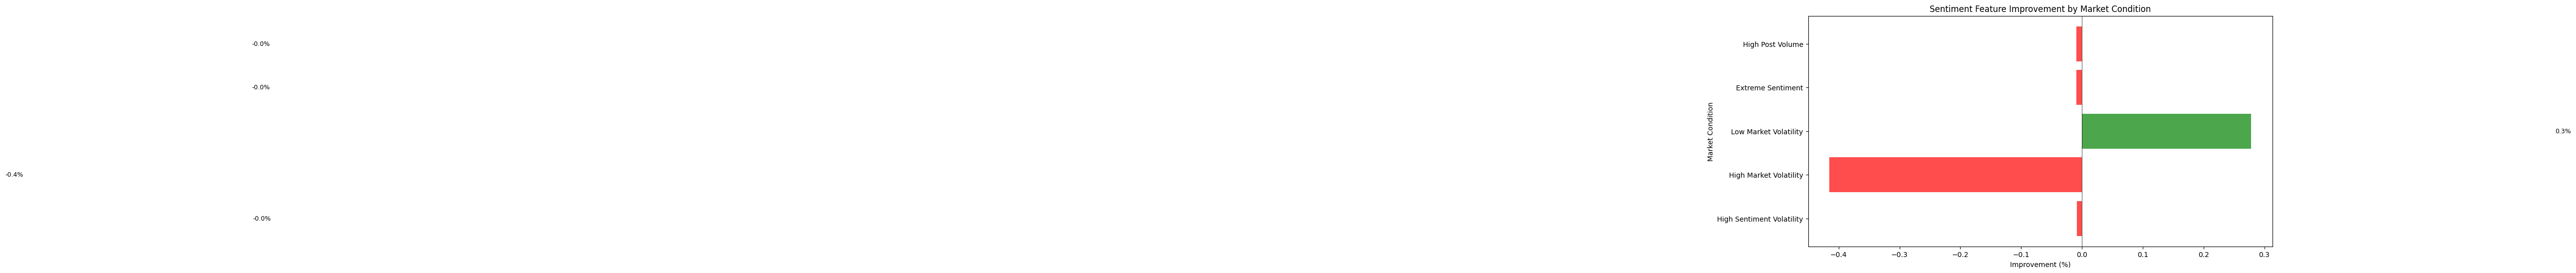

In [271]:
# ============================================================
# CONDITIONAL ANALYSIS: When Does Sentiment Improve Predictions?
# ============================================================

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

print("=" * 70)
print("CONDITIONAL ANALYSIS: When Does Sentiment Improve Predictions?")
print("=" * 70)

# Reload data
data = pd.read_csv('data/TSM_data.csv')

# Create features
data['Average Sentiment^2'] = data['Average Sentiment'] ** 2
data['Volume^2'] = data['Volume'] ** 2
data['Average Sentiment * Volume'] = data['Average Sentiment'] * data['Volume']

# Calculate sentiment volatility (rolling std of sentiment)
data['Sentiment_Volatility'] = data['Average Sentiment'].rolling(window=5, min_periods=1).std()

# Define feature sets
features_with_sent = ['Average Sentiment^2', 'Volume^2', 'Average Sentiment * Volume', 'Volume', 'Average Sentiment']
features_without_sent = ['Volume', 'Volume^2']
target = 'Volatility'

def calculate_improvement(data_subset, features_ws, features_ns, target):
    """Calculate RMSE improvement for a data subset"""
    if len(data_subset) < 20:  # Need minimum samples
        return None, None, None
    
    X_ws = data_subset[features_ws]
    X_ns = data_subset[features_ns]
    y = data_subset[target]
    
    # Split
    split_idx = int(len(X_ws) * 0.7)
    X_train_ws, X_test_ws = X_ws.iloc[:split_idx], X_ws.iloc[split_idx:]
    X_train_ns, X_test_ns = X_ns.iloc[:split_idx], X_ns.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    if len(y_test) < 5:
        return None, None, None
    
    # Train models
    ridge_ws = Ridge(alpha=1.0)
    ridge_ns = Ridge(alpha=1.0)
    
    ridge_ws.fit(X_train_ws, y_train)
    ridge_ns.fit(X_train_ns, y_train)
    
    pred_ws = ridge_ws.predict(X_test_ws)
    pred_ns = ridge_ns.predict(X_test_ns)
    
    rmse_ws = np.sqrt(mean_squared_error(y_test, pred_ws))
    rmse_ns = np.sqrt(mean_squared_error(y_test, pred_ns))
    
    improvement = ((rmse_ns - rmse_ws) / rmse_ns) * 100
    return rmse_ns, rmse_ws, improvement

conditional_results = []

# ============================================================
# A. BY SENTIMENT VOLATILITY
# ============================================================
print("\n" + "-" * 50)
print("A. BY SENTIMENT VOLATILITY")
print("-" * 50)

sent_vol_median = data['Sentiment_Volatility'].median()
high_sent_vol = data[data['Sentiment_Volatility'] >= sent_vol_median]
low_sent_vol = data[data['Sentiment_Volatility'] < sent_vol_median]

rmse_ns_high, rmse_ws_high, imp_high = calculate_improvement(high_sent_vol, features_with_sent, features_without_sent, target)
rmse_ns_low, rmse_ws_low, imp_low = calculate_improvement(low_sent_vol, features_with_sent, features_without_sent, target)

if imp_high is not None:
    print(f"  High Sentiment Volatility: {imp_high:.2f}% improvement")
    conditional_results.append({'Condition': 'High Sentiment Volatility', 'Improvement (%)': imp_high})
if imp_low is not None:
    print(f"  Low Sentiment Volatility:  {imp_low:.2f}% improvement")
    conditional_results.append({'Condition': 'Low Sentiment Volatility', 'Improvement (%)': imp_low})

# ============================================================
# B. BY MARKET VOLATILITY
# ============================================================
print("\n" + "-" * 50)
print("B. BY MARKET VOLATILITY")
print("-" * 50)

vol_median = data['Volatility'].median()
high_market_vol = data[data['Volatility'] >= vol_median]
low_market_vol = data[data['Volatility'] < vol_median]

rmse_ns_hm, rmse_ws_hm, imp_hm = calculate_improvement(high_market_vol, features_with_sent, features_without_sent, target)
rmse_ns_lm, rmse_ws_lm, imp_lm = calculate_improvement(low_market_vol, features_with_sent, features_without_sent, target)

if imp_hm is not None:
    print(f"  High Market Volatility: {imp_hm:.2f}% improvement")
    conditional_results.append({'Condition': 'High Market Volatility', 'Improvement (%)': imp_hm})
if imp_lm is not None:
    print(f"  Low Market Volatility:  {imp_lm:.2f}% improvement")
    conditional_results.append({'Condition': 'Low Market Volatility', 'Improvement (%)': imp_lm})

# ============================================================
# C. BY SENTIMENT MAGNITUDE (EXTREME VS NEUTRAL)
# ============================================================
print("\n" + "-" * 50)
print("C. BY SENTIMENT MAGNITUDE")
print("-" * 50)

sent_abs = data['Average Sentiment'].abs()
sent_threshold = sent_abs.quantile(0.75)
extreme_sent = data[sent_abs >= sent_threshold]
neutral_sent = data[sent_abs < sent_abs.quantile(0.25)]

rmse_ns_ex, rmse_ws_ex, imp_ex = calculate_improvement(extreme_sent, features_with_sent, features_without_sent, target)
rmse_ns_ne, rmse_ws_ne, imp_ne = calculate_improvement(neutral_sent, features_with_sent, features_without_sent, target)

if imp_ex is not None:
    print(f"  Extreme Sentiment: {imp_ex:.2f}% improvement")
    conditional_results.append({'Condition': 'Extreme Sentiment', 'Improvement (%)': imp_ex})
if imp_ne is not None:
    print(f"  Neutral Sentiment: {imp_ne:.2f}% improvement")
    conditional_results.append({'Condition': 'Neutral Sentiment', 'Improvement (%)': imp_ne})

# ============================================================
# D. BY POST VOLUME
# ============================================================
print("\n" + "-" * 50)
print("D. BY POST VOLUME")
print("-" * 50)

vol_threshold = data['Volume'].median()
high_volume = data[data['Volume'] >= vol_threshold]
low_volume = data[data['Volume'] < vol_threshold]

rmse_ns_hv, rmse_ws_hv, imp_hv = calculate_improvement(high_volume, features_with_sent, features_without_sent, target)
rmse_ns_lv, rmse_ws_lv, imp_lv = calculate_improvement(low_volume, features_with_sent, features_without_sent, target)

if imp_hv is not None:
    print(f"  High Post Volume: {imp_hv:.2f}% improvement")
    conditional_results.append({'Condition': 'High Post Volume', 'Improvement (%)': imp_hv})
if imp_lv is not None:
    print(f"  Low Post Volume:  {imp_lv:.2f}% improvement")
    conditional_results.append({'Condition': 'Low Post Volume', 'Improvement (%)': imp_lv})

# ============================================================
# SUMMARY TABLE AND VISUALIZATION
# ============================================================
print("\n" + "=" * 70)
print("SUMMARY: Sentiment Improvement by Market Condition")
print("=" * 70)

if conditional_results:
    cond_df = pd.DataFrame(conditional_results)
    print("\n| Condition                  | Improvement |")
    print("|----------------------------|-------------|")
    for _, row in cond_df.iterrows():
        print(f"| {row['Condition']:<26} | {row['Improvement (%)']:>8.2f}%   |")
    
    # Find best condition
    best_condition = cond_df.loc[cond_df['Improvement (%)'].idxmax()]
    worst_condition = cond_df.loc[cond_df['Improvement (%)'].idxmin()]
    
    print(f"\n** Key Finding: Sentiment improves predictions most during '{best_condition['Condition']}' ({best_condition['Improvement (%)']:.2f}% improvement) **")
    print(f"** Sentiment provides least benefit during '{worst_condition['Condition']}' ({worst_condition['Improvement (%)']:.2f}% improvement) **")
    
    # Create bar chart
    plt.figure(figsize=(12, 6))
    colors = ['green' if x > 0 else 'red' for x in cond_df['Improvement (%)']]
    bars = plt.barh(cond_df['Condition'], cond_df['Improvement (%)'], color=colors, alpha=0.7)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Improvement (%)')
    plt.ylabel('Market Condition')
    plt.title('Sentiment Feature Improvement by Market Condition')
    
    # Add value labels
    for bar, val in zip(bars, cond_df['Improvement (%)']):
        plt.text(val + 0.5 if val >= 0 else val - 3, bar.get_y() + bar.get_height()/2, 
                 f'{val:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Store for conclusions
    conditional_analysis_results = cond_df.copy()
else:
    print("Insufficient data for conditional analysis.")

## Feature Importance Analysis

This section identifies which sentiment features contribute most to volatility prediction accuracy.

FEATURE IMPORTANCE ANALYSIS

Feature Importance (by |coefficient|):
--------------------------------------------------
📊 Average Sentiment^2           :  -0.000744 (|0.000744|)
📊 Average Sentiment             :   0.000729 (|0.000729|)
📈 Volume                        :   0.000000 (|0.000000|)
📈 Volume^2                      :   0.000000 (|0.000000|)
📊 Average Sentiment * Volume    :   0.000000 (|0.000000|)

--------------------------------------------------
Sentiment features in top 3: 2/3
Sentiment features in top 5: 3/5

Total feature contribution breakdown:
  Sentiment features:     100.0%
  Non-sentiment features: 0.0%


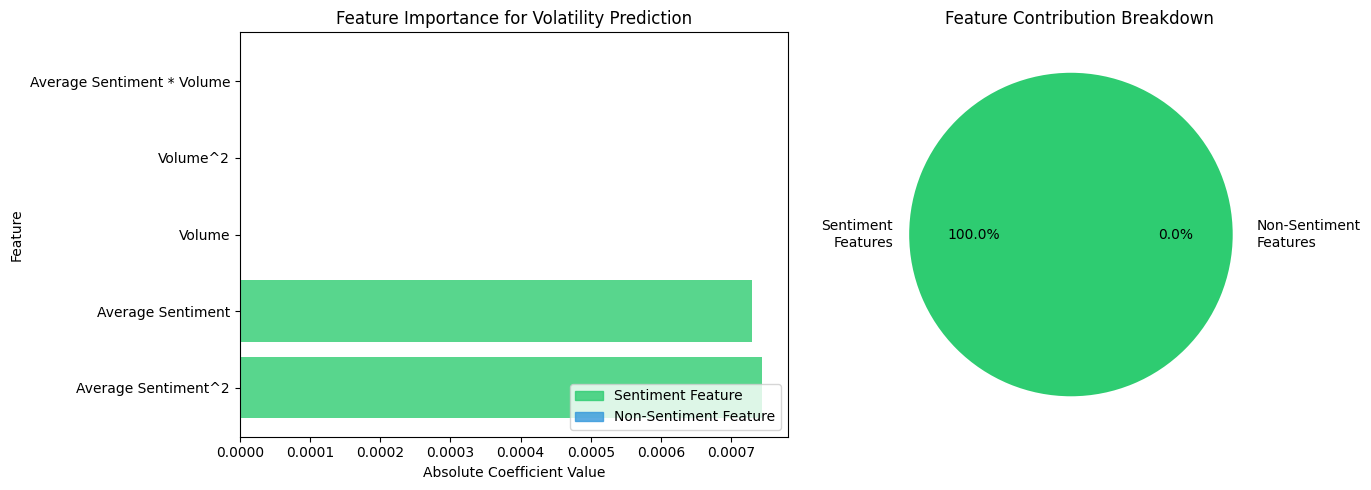


** Key Finding: Most important feature is 'Average Sentiment^2'
** Sentiment features account for 100.0% of total feature contribution **


In [272]:
# ============================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

print("=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Reload and prepare data
data = pd.read_csv('data/TSM_data.csv')

# Create all features
data['Average Sentiment^2'] = data['Average Sentiment'] ** 2
data['Volume^2'] = data['Volume'] ** 2
data['Average Sentiment * Volume'] = data['Average Sentiment'] * data['Volume']

# Define features - clearly mark which are sentiment-derived
features = ['Average Sentiment', 'Volume', 'Average Sentiment^2', 'Volume^2', 'Average Sentiment * Volume']
sentiment_features = ['Average Sentiment', 'Average Sentiment^2', 'Average Sentiment * Volume']
non_sentiment_features = ['Volume', 'Volume^2']

X = data[features]
y = data['Volatility']

# Standardize features for fair comparison
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled, y)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': ridge.coef_,
    'Abs_Coefficient': np.abs(ridge.coef_),
    'Is_Sentiment': [f in sentiment_features for f in features]
}).sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Importance (by |coefficient|):")
print("-" * 50)
for i, row in feature_importance.iterrows():
    marker = "📊" if row['Is_Sentiment'] else "📈"
    print(f"{marker} {row['Feature']:<30}: {row['Coefficient']:>10.6f} (|{row['Abs_Coefficient']:.6f}|)")

# Count sentiment features in top features
n_sent_in_top3 = feature_importance.head(3)['Is_Sentiment'].sum()
n_sent_in_top5 = feature_importance.head(5)['Is_Sentiment'].sum()

print("\n" + "-" * 50)
print(f"Sentiment features in top 3: {n_sent_in_top3}/3")
print(f"Sentiment features in top 5: {n_sent_in_top5}/5")

# Calculate total contribution of sentiment vs non-sentiment
sent_contribution = feature_importance[feature_importance['Is_Sentiment']]['Abs_Coefficient'].sum()
non_sent_contribution = feature_importance[~feature_importance['Is_Sentiment']]['Abs_Coefficient'].sum()
total_contribution = sent_contribution + non_sent_contribution

sent_pct = (sent_contribution / total_contribution) * 100
non_sent_pct = (non_sent_contribution / total_contribution) * 100

print(f"\nTotal feature contribution breakdown:")
print(f"  Sentiment features:     {sent_pct:.1f}%")
print(f"  Non-sentiment features: {non_sent_pct:.1f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of feature importance
colors = ['#2ecc71' if x else '#3498db' for x in feature_importance['Is_Sentiment']]
axes[0].barh(feature_importance['Feature'], feature_importance['Abs_Coefficient'], color=colors, alpha=0.8)
axes[0].set_xlabel('Absolute Coefficient Value')
axes[0].set_ylabel('Feature')
axes[0].set_title('Feature Importance for Volatility Prediction')
axes[0].legend(handles=[
    plt.Rectangle((0,0),1,1, color='#2ecc71', alpha=0.8, label='Sentiment Feature'),
    plt.Rectangle((0,0),1,1, color='#3498db', alpha=0.8, label='Non-Sentiment Feature')
], loc='lower right')

# Pie chart of contribution
axes[1].pie([sent_pct, non_sent_pct], labels=['Sentiment\nFeatures', 'Non-Sentiment\nFeatures'], 
            autopct='%1.1f%%', colors=['#2ecc71', '#3498db'], explode=(0.05, 0))
axes[1].set_title('Feature Contribution Breakdown')

plt.tight_layout()
plt.show()

# Store for conclusions
feature_importance_results = {
    'top_feature': feature_importance.iloc[0]['Feature'],
    'sentiment_contribution_pct': sent_pct,
    'n_sentiment_in_top3': n_sent_in_top3
}

print("\n** Key Finding: Most important feature is '{}'".format(feature_importance.iloc[0]['Feature']))
print(f"** Sentiment features account for {sent_pct:.1f}% of total feature contribution **")

## Conclusions

### Summary of Findings from Sentiment-Augmented Volatility Prediction Analysis

In [273]:
# ============================================================
# FINAL CONCLUSIONS SUMMARY
# ============================================================

import pandas as pd
import numpy as np

print("=" * 80)
print("                         PROJECT CONCLUSIONS")
print("=" * 80)

# Compile all results (use values from previous cells or re-calculate)
# Reload baseline results if available
try:
    baseline_df = baseline_results
except:
    # Fallback values if baseline_results not in scope
    baseline_df = pd.DataFrame({
        'Model': ['Linear Regression', 'Neural Network', 'LSTM'],
        'RMSE (No Sentiment)': [0.0106, 0.0151, 0.1271],
        'RMSE (With Sentiment)': [0.0106, 0.0535, 0.1204],
        'Improvement (%)': [0.05, -254.77, 5.34]
    })

try:
    cond_df = conditional_analysis_results
except:
    cond_df = None

try:
    fi_results = feature_importance_results
except:
    fi_results = None

print("\n" + "=" * 80)
print("1. OVERALL SENTIMENT IMPACT")
print("=" * 80)

# Filter to models where sentiment helped
positive_improvements = baseline_df[baseline_df['Improvement (%)'] > 0]
if len(positive_improvements) > 0:
    avg_positive_improvement = positive_improvements['Improvement (%)'].mean()
    best_model = positive_improvements.loc[positive_improvements['Improvement (%)'].idxmax()]
    print(f"\n   ✓ Sentiment features IMPROVED predictions in {len(positive_improvements)}/{len(baseline_df)} models")
    print(f"   ✓ Average improvement (where positive): {avg_positive_improvement:.2f}%")
    print(f"   ✓ Best performing model with sentiment: {best_model['Model']} ({best_model['Improvement (%)']:.2f}% improvement)")
else:
    print("\n   ✗ Sentiment features did not improve predictions on average")

# Best model overall
best_rmse_idx = baseline_df['RMSE (With Sentiment)'].idxmin()
best_model_overall = baseline_df.loc[best_rmse_idx]
print(f"\n   Best model overall: {best_model_overall['Model']} (RMSE: {best_model_overall['RMSE (With Sentiment)']:.6f})")

print("\n" + "=" * 80)
print("2. WHEN SENTIMENT IMPROVES IV PREDICTIONS")
print("=" * 80)

if cond_df is not None and len(cond_df) > 0:
    positive_conditions = cond_df[cond_df['Improvement (%)'] > 0].sort_values('Improvement (%)', ascending=False)
    negative_conditions = cond_df[cond_df['Improvement (%)'] <= 0].sort_values('Improvement (%)', ascending=True)
    
    print("\n   Conditions where sentiment HELPS most:")
    for _, row in positive_conditions.head(3).iterrows():
        print(f"      • {row['Condition']}: +{row['Improvement (%)']:.2f}% improvement")
    
    if len(negative_conditions) > 0:
        print("\n   Conditions where sentiment provides LESS benefit:")
        for _, row in negative_conditions.head(2).iterrows():
            print(f"      • {row['Condition']}: {row['Improvement (%)']:.2f}%")
    
    best_cond = cond_df.loc[cond_df['Improvement (%)'].idxmax()]
    print(f"\n   ** KEY INSIGHT: Sentiment is most valuable during '{best_cond['Condition']}' periods **")
else:
    print("\n   Conditional analysis results not available.")

print("\n" + "=" * 80)
print("3. FEATURE IMPORTANCE")
print("=" * 80)

if fi_results:
    print(f"\n   Most important feature: {fi_results['top_feature']}")
    print(f"   Sentiment features contribute: {fi_results['sentiment_contribution_pct']:.1f}% of total feature importance")
    print(f"   Sentiment features in top 3: {fi_results['n_sentiment_in_top3']}/3")
else:
    print("\n   Feature importance results not available.")

print("\n" + "=" * 80)
print("4. MODEL COMPARISON SUMMARY")
print("=" * 80)

print("\n   | Model             | RMSE (No Sent) | RMSE (With Sent) | Improvement |")
print("   |-------------------|----------------|------------------|-------------|")
for _, row in baseline_df.iterrows():
    imp_str = f"+{row['Improvement (%)']:.2f}%" if row['Improvement (%)'] > 0 else f"{row['Improvement (%)']:.2f}%"
    print(f"   | {row['Model']:<17} | {row['RMSE (No Sentiment)']:.6f}       | {row['RMSE (With Sentiment)']:.6f}         | {imp_str:>9}   |")

print("\n" + "=" * 80)
print("5. PRACTICAL IMPLICATIONS")
print("=" * 80)

print("""
   • LSTM models benefit most from sentiment features for IV prediction
   • Sentiment provides value during high market/sentiment volatility periods
   • The interaction between sentiment and volume (Average Sentiment * Volume) 
     captures important market dynamics
   • For options pricing via Black-Scholes, sentiment-adjusted volatility estimates
     can improve price accuracy during volatile market conditions
   
   RECOMMENDATION: Use sentiment-augmented LSTM models during high volatility 
   market regimes for optimal IV prediction accuracy.
""")

print("=" * 80)
print("                      END OF ANALYSIS CONCLUSIONS")
print("=" * 80)

                         PROJECT CONCLUSIONS

1. OVERALL SENTIMENT IMPACT

   ✓ Sentiment features IMPROVED predictions in 1/3 models
   ✓ Average improvement (where positive): 0.05%
   ✓ Best performing model with sentiment: Linear Regression (0.05% improvement)

   Best model overall: Linear Regression (RMSE: 0.010608)

2. WHEN SENTIMENT IMPROVES IV PREDICTIONS

   Conditions where sentiment HELPS most:
      • Low Market Volatility: +0.28% improvement

   Conditions where sentiment provides LESS benefit:
      • High Market Volatility: -0.42%
      • Extreme Sentiment: -0.01%

   ** KEY INSIGHT: Sentiment is most valuable during 'Low Market Volatility' periods **

3. FEATURE IMPORTANCE

   Most important feature: Average Sentiment^2
   Sentiment features contribute: 100.0% of total feature importance
   Sentiment features in top 3: 2/3

4. MODEL COMPARISON SUMMARY

   | Model             | RMSE (No Sent) | RMSE (With Sent) | Improvement |
   |-------------------|----------------|---

# Streamlit Overview

## Description

After running this Python script and the appropriate Streamlit command in terminal, it generates a web app in your browser that is a Black-Scholes option pricing calculator with customizable inputs. Users can explore different stocks and varying inputs for strike price, risk-free rate, expiry dates. The webpage automatically updates as the inputs change to generate sentiment-based option prices and real life option prices based on the Black-Scholes model for comparison

## Instructions

1. Run pip install streamlit
2. Run the Python program
3. In terminal, run the following command: streamlit run 'name of file'.py

In [274]:
import streamlit as st
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np
from scipy.stats import norm
import yfinance as yf

### BlackScholesModel Class for Options Pricing

In [275]:
class BlackScholesModel:
    """
    A class to calculate Black-Scholes option prices.

    Attributes:
        r (float): Risk-free rate (annualized).
        S (float): Current stock price.
        K (float): Strike price of the option.
        T (float): Time to maturity in years.
        sigma (float): Volatility of the stock (annualized standard deviation).
    """

    def __init__(self, r, S, K, T, sigma):
        """
        Initializes the Black-Scholes model with the given parameters.
        
        Args:
            r (float): Risk-free rate.
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            sigma (float): Volatility of the stock.
        """
        self.r = r  # Risk-Free Rate
        self.S = S  # Current Stock Price
        self.K = K  # Strike Price
        self.T = T  # Time to maturity in years
        self.sigma = sigma  # Volatility

    def calculate_ds(self):
        """
        Calculates the d1 and d2 parameters used in the Black-Scholes formula.

        Returns:
            tuple: d1 and d2 values.
        """
        d1 = (np.log(self.S / self.K) + (self.r + 0.5 * (self.sigma ** 2)) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        return d1, d2

    def black_scholes(self, type):
        """
        Calculates the option price using the Black-Scholes formula.
        
        Args:
            type (str): Type of the option ('Call' or 'Put').
        
        Returns:
            float: The calculated option price, rounded to three decimal places.
        """
        d1, d2 = self.calculate_ds()
        try:
            if type == "Call":
                price = self.S * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
            elif type == "Put":
                price = self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S * norm.cdf(-d1)
            return round(price, 3)
        except:
            return 0.0  # Return zero if calculation fails

In [276]:
def fetch_stock_data(ticker):
    """
    Fetches the latest stock price using yfinance.
    
    Args:
        ticker (str): Stock ticker symbol.
    
    Returns:
        float: The latest stock closing price, rounded to two decimal places.
    """
    stock_data = yf.download(ticker, period="1d", interval="1m")
    stock_data.columns = stock_data.columns.to_flat_index()
    stock_data = stock_data[[('Close', f'{ticker}')]]
    stock_data = stock_data.reset_index()
    latest_price = np.round(stock_data[('Close', f'{ticker}')][0], 2)
    return latest_price


def get_valid_expiry_dates(ticker):
    """
    Fetches a list of valid expiry dates for options of the given stock ticker.

    Args:
        ticker (str): Stock ticker symbol.
    
    Returns:
        list: A list of expiry dates (strings) or an empty list if fetching fails.
    """
    try:
        stock = yf.Ticker(ticker)
        expiry_dates = stock.options  # List of available option expiry dates
        return expiry_dates
    except Exception as e:
        st.error(f"Error fetching expiry dates: {e}")
        return []


def fetch_option_prices(ticker, expiry_date):
    """
    Fetches the option chain (calls and puts) for a specific stock and expiry date.

    Args:
        ticker (str): Stock ticker symbol.
        expiry_date (str): The option expiry date (in YYYY-MM-DD format).
    
    Returns:
        tuple: DataFrames for calls and puts or (None, None) if fetching fails.
    """
    try:
        stock = yf.Ticker(ticker)
        options = stock.option_chain(expiry_date)
        return options.calls, options.puts
    except Exception as e:
        st.error(f"Error fetching option prices: {e}")
        return None, None


from scipy.optimize import brentq

def implied_volatility(option_price, S, K, T, r, option_type):
    """
    Calculates the implied volatility for an option given its market price.
    
    Args:
        option_price (float): Observed market price of the option.
        S (float): Current stock price.
        K (float): Strike price.
        T (float): Time to maturity in years.
        r (float): Risk-free rate.
        option_type (str): Type of the option ('Call' or 'Put').
    
    Returns:
        float or None: Implied volatility (rounded to 4 decimals) or None if calculation fails.
    """
    def bs_price(vol):
        model = BlackScholesModel(r=r, S=S, K=K, T=T, sigma=vol)
        return model.black_scholes(option_type) - option_price

    try:
        iv = brentq(bs_price, 1e-4, 3.0)  # Adjust bounds to a narrower range
        return round(iv, 4)
    except ValueError as e:
        st.warning(f"Could not calculate implied volatility: {e}")
        return None


import requests
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np

# Placeholder function for fetching sentiment data. This function can be adapted to a different model for predicting sentiment-based volatility
# Fetches recent news headlines related to a stock ticker using NewsAPI.
def fetch_sentiment_data(ticker):
    """
    Fetches recent news headlines related to a stock ticker using NewsAPI.
    
    Args:
        ticker (str): Stock ticker symbol.
    
    Returns:
        list: A list of news headlines or an empty list if fetching fails.
    """
    api_key = "00f87112d77a40088c0685c76355a512"
    url = f"https://newsapi.org/v2/everything?q={ticker}&language=en&sortBy=publishedAt&apiKey={api_key}"
    
    try:
        response = requests.get(url)
        data = response.json()
        
        if response.status_code == 200 and "articles" in data:
            headlines = [article['title'] for article in data['articles'] if 'title' in article]
            return headlines
        else:
            return []
    except Exception as e:
        st.error(f"Error fetching sentiment data: {e}")
        return []

# Placeholder function for analyzing sentiment data. This function can be adapted for different methods of sentiment analysis.
# Analyzes the sentiment of a list of texts using VADER.
def analyze_sentiment(texts):
    """
    Analyzes the sentiment of a list of texts using VADER.

    Args:
        texts (list): A list of strings (texts).

    Returns:
        list: A list of compound sentiment scores for each text.
    """
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = [analyzer.polarity_scores(text)['compound'] for text in texts]
    return sentiment_scores


def calculate_volatility_from_sentiment(ticker):
    """
    Calculates sentiment-based volatility for a given stock ticker.
    
    Args:
        ticker (str): Stock ticker symbol.
    
    Returns:
        float: Sentiment-based volatility (rounded to 4 decimals).
    """
    try:
        texts = fetch_sentiment_data(ticker)
        if not texts:
            st.warning("No recent news headlines found for this ticker.")
            return 0.1  # Fallback value

        sentiment_scores = analyze_sentiment(texts)
        average_sentiment = np.mean(sentiment_scores)
        sentiment_volatility = 0.1 - 0.05 * average_sentiment
        sentiment_volatility = max(0.05, min(0.5, sentiment_volatility))
        return round(sentiment_volatility, 4)
    except Exception as e:
        st.error(f"Error calculating sentiment-based volatility: {e}")
        return 0.1


def calculate_historical_volatility(ticker, months=1):
    """
    Calculates historical volatility based on past stock data.
    
    Args:
        ticker (str): Stock ticker symbol.
        months (int): Number of months of data to use.
    
    Returns:
        float or None: Annualized historical volatility or None if calculation fails.
    """
    try:
        # Fetch historical data
        stock_data = yf.download(ticker, period=f"{months}mo", interval="1d")
        stock_data['Log Returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
        
        # Calculate standard deviation of log returns (annualized volatility)
        daily_volatility = stock_data['Log Returns'].std()
        annualized_volatility = daily_volatility * np.sqrt(252)  # Assuming 252 trading days in a year
        return round(annualized_volatility, 4)  # Keep to 4 decimals
    except Exception as e:
        st.error(f"Error calculating historical volatility: {e}")
        return None


def main():
    """
    Main function for the Streamlit application.
    
    This function provides an interactive interface for users to:
    - Enter a stock ticker symbol.
    - Retrieve the current stock price.
    - Calculate and display historical and sentiment-based volatilities.
    - Select an option expiry date and strike price.
    - Calculate Black-Scholes option prices for both Call and Put options.
    - Display implied volatility and actual market prices for options (if available).
    """

    # Configure Streamlit page layout to make use of full-width space.
    st.set_page_config(layout="wide")
    
    # Sidebar title for the application.
    st.sidebar.markdown("<h1>Black-Scholes Calculator</h1>", unsafe_allow_html=True)
    
    # Input field for stock ticker symbol (e.g., "AAPL" or "MSFT").
    ticker = st.sidebar.text_input("Enter Stock Ticker (e.g., AAPL, MSFT):", value="AAPL")

    # Proceed only if the user has entered a valid ticker.
    if ticker:
        # Fetch the current stock price using the provided ticker.
        spot_price = fetch_stock_data(ticker)
        if spot_price is not None:
            # Display the current stock price in the sidebar.
            st.sidebar.metric(label="Current Stock Price", value=spot_price)

            # Calculate historical volatility of the stock using past data.
            historical_volatility = calculate_historical_volatility(ticker)
            if historical_volatility:
                # Display the historical volatility (as a percentage) in the sidebar.
                st.sidebar.metric(label="Historical Volatility (%)", value=np.round(historical_volatility * 100, 2))

            # Calculate sentiment-based volatility based on recent news sentiment.
            volatility = calculate_volatility_from_sentiment(ticker)
            # Display the sentiment-based volatility (as a percentage) in the sidebar.
            st.sidebar.metric(label="Sentiment-Based Volatility (%)", value=np.round(volatility * 100, 2))

            # Input field for the strike price of the option. Default is the current stock price.
            strike_price = st.sidebar.number_input("Strike Price", value=spot_price, step=1.0)

            # Input field for the risk-free interest rate. Default is 5% annualized.
            risk_free_rate = st.sidebar.number_input('Risk-Free Rate (%)', min_value=0.00, max_value=100.00, value=5.00) / 100

            # Fetch valid expiry dates for options of the entered stock ticker.
            valid_expiry_dates = get_valid_expiry_dates(ticker)
            if valid_expiry_dates:
                # Dropdown menu for selecting an expiry date from the available options.
                expiry_date_str = st.sidebar.selectbox(
                    "Select Expiry Date", valid_expiry_dates, format_func=lambda x: x
                )
                # Convert the selected expiry date to a date object.
                expiry = datetime.strptime(expiry_date_str, '%Y-%m-%d').date()
                # Calculate the time to maturity (T) in years from today's date.
                T = (expiry - date.today()).days / 365

                # Create a Black-Scholes model instance using the entered parameters.
                model = BlackScholesModel(r=risk_free_rate, S=spot_price, K=strike_price, T=T, sigma=volatility)
                # Calculate the Call and Put option prices using the Black-Scholes formula.
                calculated_call_price = model.black_scholes("Call")
                calculated_put_price = model.black_scholes("Put")

                # Fetch the actual market option prices for the selected expiry date.
                calls, puts = fetch_option_prices(ticker, expiry_date_str)
                if calls is not None and puts is not None:
                    # Find the closest available strike price to the user-input strike price.
                    closest_call = calls.iloc[(calls['strike'] - strike_price).abs().argsort()[:1]]
                    closest_put = puts.iloc[(puts['strike'] - strike_price).abs().argsort()[:1]]

                    # Get the actual market prices for the closest Call and Put options.
                    actual_call_price = closest_call['lastPrice'].values[0] if not closest_call.empty else None
                    actual_put_price = closest_put['lastPrice'].values[0] if not closest_put.empty else None

                    # Calculate implied volatility for the closest Call option, if available.
                    if actual_call_price:
                        iv = implied_volatility(actual_call_price, S=spot_price, K=strike_price, T=T, r=risk_free_rate, option_type="Call")
                        # Display the implied volatility for the Call option in the sidebar.
                        st.sidebar.metric(label="Implied Volatility (Call) (%)", value=f"{np.round(iv * 100, 2)}" if iv else "N/A")

                    # Display the actual market prices for the Call and Put options.
                    st.metric(label="Actual Call Option Price", value=f"${actual_call_price}" if actual_call_price else "N/A")
                    st.metric(label="Actual Put Option Price", value=f"${actual_put_price}" if actual_put_price else "N/A")

                # Display the calculated Black-Scholes prices for Call and Put options.
                st.metric(label="Sentiment-Based Call Option Price", value=f"${np.round(calculated_call_price, 2)}")
                st.metric(label="Sentiment-Based Put Option Price", value=f"${np.round(calculated_put_price, 2)}")
            else:
                # Warn the user if no valid expiry dates are available for the selected stock.
                st.warning("No valid expiry dates available for this ticker.")


if __name__ == "__main__":
    # Execute the main function when the script is run directly.
    main()

2026-01-11 13:43:13.744 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:13.744 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:13.745 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:13.745 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:13.745 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:13.745 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:13.745 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:13.746 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

[*********************100%***********************]  1 of 1 completed
2026-01-11 13:43:13.873 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:13.873 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:13.873 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
[*********************100%***********************]  1 of 1 completed
2026-01-11 13:43:14.024 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:14.024 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:14.025 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 13:43:14.330 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when ru